# Polarization analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc

import pertpy

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

To download processed data:
```bash
DROPBOX_PATH=GRNPerturbSeq/3_expts/Diff035scRNAseq/
DATADIR=/mnt/oak/users/emma/data/GWT/

rclone copy dropbox:${DROPBOX_PATH}Diff035_pseudobulk.h5ad ${DATADIR} --checksum --ignore-times
rclone copy dropbox:${DROPBOX_PATH}Diff035_merged.gex.filtered.h5ad ${DATADIR} --checksum --ignore-times
```

In [4]:
DATADIR='/mnt/oak/users/emma/data/GWT/'
os.listdir(DATADIR)

['K562_gwps_filt_pseudobulk_batch_197.h5ad',
 'K562_gwps_filt_pseudobulk_batch_215.h5ad',
 'K562_gwps_filt_pseudobulk_batch_83.h5ad',
 'K562_gwps_filt_pseudobulk_batch_201.h5ad',
 'K562_gwps_filt_pseudobulk_batch_139.h5ad',
 'CD4iR1_Psomagen',
 'K562_gwps_filt_pseudobulk_batch_113.h5ad',
 'K562_gwps_filt_pseudobulk_batch_183.h5ad',
 'K562_gwps_filt_pseudobulk_batch_107.h5ad',
 'K562_gwps_filt_pseudobulk_batch_51.h5ad',
 'K562_gwps_filt_pseudobulk_batch_193.h5ad',
 'K562_gwps_filt_pseudobulk_batch_217.h5ad',
 'K562_gwps_filt_pseudobulk_batch_147.h5ad',
 'K562_gwps_filt_pseudobulk_batch_61.h5ad',
 'K562_gwps_filt_pseudobulk_batch_135.h5ad',
 'K562_gwps_filt_pseudobulk_batch_4.h5ad',
 'K562_gwps_filt_pseudobulk_batch_19.h5ad',
 'K562_gwps_filt_pseudobulk_batch_237.h5ad',
 'K562_gwps_filt_pseudobulk_batch_122.h5ad',
 'K562_gwps_filt_pseudobulk_batch_228.h5ad',
 'K562_gwps_filt_pseudobulk_batch_64.h5ad',
 'K562_gwps_filt_pseudobulk_batch_194.h5ad',
 'K562_gwps_filt_pseudobulk_batch_110.h5ad

## DE analysis on polarization experiments

In [5]:
adata = sc.read_h5ad(f'{DATADIR}/Diff035_merged.gex.filtered.h5ad', backed=True)
adata.obs['sample_id'] = adata.obs['culture_condition'].copy()
adata.obs['culture_condition'] = adata.obs['sample_id'].str.split('_').str[0]
adata.obs['timepoint'] = adata.obs['sample_id'].str.split('_').str[1]
adata.obs['timepoint'] = np.where(adata.obs['timepoint'].isna(), 'Day0', adata.obs['timepoint'])


In [15]:
# Split data into train and test sets while balancing culture_condition
from sklearn.model_selection import train_test_split

unique_conditions = adata.obs['sample_id'].unique()

train_indices = []
test_indices = []
# Split each condition separately to maintain balance
for condition in unique_conditions:
    condition_indices = adata.obs[adata.obs['sample_id'] == condition].index
    train_idx, test_idx = train_test_split(
        condition_indices,
        test_size=0.25,
        random_state=42
    )
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

adata.obs['split'] = 'train'
adata.obs.loc[test_indices, 'split'] = 'test'

print(adata.obs.groupby(['sample_id', 'split']).size().unstack())

split        test  train
sample_id               
Day0         2607   7820
Th0_8hr      2246   6738
Th0_Day3     3654  10960
Th0_Day5     4157  12470
Th0_Day7     3126   9375
Th0_Day9     3346  10035
Th0_Restim   3070   9208
Th1_8hr      2198   6592
Th1_Day3     3320   9958
Th1_Day5     4261  12782
Th1_Day7     3230   9689
Th1_Day9     3076   9228
Th1_Restim   2610   7828
Th2_8hr      2366   7096
Th2_Day3     3598  10791
Th2_Day5     3781  11343
Th2_Day7     4912  14736
Th2_Day9     3813  11437
Th2_Restim   3047   9139
Th17_8hr     2341   7021
Th17_Day3    4091  12271
Th17_Day5    3235   9703
Th17_Day7    2852   8555
Th17_Day9    2196   6585
Th17_Restim  2537   7609
Treg_8hr     2144   6431
Treg_Day3    3409  10225
Treg_Day5    3432  10296
Treg_Day7    3537  10610
Treg_Day9    3271   9813
Treg_Restim  2841   8521


In [22]:
# Keep conditions of interest
keep_conditions = ['Th0','Th1','Th2', 'Treg']
keep_timepoints = ['Day3','Day5','Day7', 'Day9']
condition_mask = (adata.obs['timepoint'].isin(keep_timepoints)) & (adata.obs['culture_condition'].isin(keep_conditions)) 
adata_train = adata[condition_mask & (adata.obs['split'] == 'train')].to_memory()
adata_train

AnnData object with n_obs × n_vars = 173748 × 18129
    obs: 'culture_condition', 'total_counts', 'pct_counts_mt', 'n_genes', 'sample_id', 'timepoint', 'split'
    var: 'gene_name', 'mt'

In [31]:
# pbulk_adata = sc.read_h5ad(f'{DATADIR}/Diff035_pseudobulk.h5ad')
# pbulk_adata.obs['sample_id'] = pbulk_adata.obs['culture_condition'].copy()
# pbulk_adata.obs['culture_condition'] = pbulk_adata.obs['sample_id'].str.split('_').str[0]
# pbulk_adata.obs['timepoint'] = pbulk_adata.obs['sample_id'].str.split('_').str[1]
# pbulk_adata.obs['timepoint'] = np.where(pbulk_adata.obs['timepoint'].isna(), 'Day0', pbulk_adata.obs['timepoint'])

pbulk_adata = sc.get.aggregate(adata_train, by=['sample_id', 'timepoint', 'culture_condition'], func=['sum'])

# Filter out lowly expressed genes
pbulk_adata.var['mean_expression'] = pbulk_adata.layers['sum'].mean(axis=0)
pbulk_adata = pbulk_adata[:, pbulk_adata.var['mean_expression'] > 1].copy()

# HVGs
pbulk_adata.X = pbulk_adata.layers['sum'].copy()
sc.pp.normalize_total(pbulk_adata)
sc.pp.log1p(pbulk_adata)
sc.pp.highly_variable_genes(pbulk_adata, n_top_genes=10000)
pbulk_adata = pbulk_adata[:, pbulk_adata.var['highly_variable']].copy()
pbulk_adata.X = pbulk_adata.layers['sum'].copy()

In [48]:
# Make replication set
adata_test = adata[condition_mask & (adata.obs['split'] == 'test')].to_memory()
adata_test = adata_test[:, pbulk_adata.var_names].copy()
pbulk_adata_test = sc.get.aggregate(adata_test, by=['sample_id', 'timepoint', 'culture_condition'], func=['sum'])
pbulk_adata_test.X = pbulk_adata_test.layers['sum'].copy()

In [55]:
adata_train

AnnData object with n_obs × n_vars = 173748 × 18129
    obs: 'culture_condition', 'total_counts', 'pct_counts_mt', 'n_genes', 'sample_id', 'timepoint', 'split'
    var: 'gene_name', 'mt'

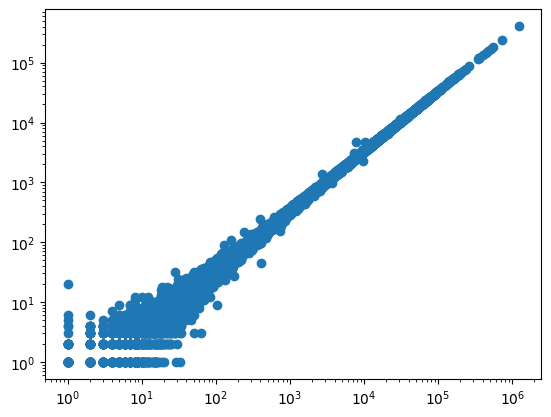

In [56]:
plt.scatter(pbulk_adata['Th0_Day3_Day3_Th0'].X.toarray(),
pbulk_adata_test['Th0_Day3_Day3_Th0'].X.toarray());
plt.xscale('log');
plt.yscale('log');

DE testing in discovery set

In [66]:
model = pertpy.tl.PyDESeq2(pbulk_adata, design='~ timepoint + culture_condition', layer='sum')
model.fit(quiet=True)

# Create a list to store all result dataframes
result_dfs = []

# Run differential expression for each polarization condition vs Th0
for polariz in ['Th1', 'Th2', 'Treg']:
    polariz_contrast = (model.cond(culture_condition = polariz) - model.cond(culture_condition = 'Th0')) 
    res_df = model.test_contrasts(polariz_contrast)
    res_df['contrast'] = polariz
    # Store the result dataframe in our list
    result_dfs.append(res_df)

Running Wald tests...
... done in 0.76 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 1. 0. 0.]
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DPM1             21178.200855        0.042118  0.080373  0.524035  0.600254   
SCYL3             2407.646425       -0.068453  0.157784 -0.433839  0.664405   
CFH                384.792350        0.534765  0.181309  2.949471  0.003183   
NIPAL3            5826.502893        0.004660  0.157854  0.029519  0.976451   
LAS1L             5258.329816        0.004742  0.099521  0.047646  0.961998   
...                       ...             ...       ...       ...       ...   
HOMEZ             2943.802628       -0.164399  0.130306 -1.261636  0.207080   
ENSG00000290797    631.336079        0.062772  0.359760  0.174482  0.861487   
CASTOR3P           439.981699        0.166885  0.241429  0.691237  0.489416   
FCGR1BP             25.586679        0.727764  0.668635  1.088434  0.276404   
SOD2              8317.129194        0.127418  0.1268

... done in 0.65 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 0. 1. 0.]
                     baseMean  log2FoldChange     lfcSE      stat  \
DPM1             21178.200855       -0.062027  0.080279 -0.772647   
SCYL3             2407.646425       -0.052824  0.157523 -0.335340   
CFH                384.792350       -1.468705  0.189124 -7.765821   
NIPAL3            5826.502893       -0.457050  0.157854 -2.895391   
LAS1L             5258.329816        0.152960  0.099174  1.542338   
...                       ...             ...       ...       ...   
HOMEZ             2943.802628        0.261665  0.129744  2.016786   
ENSG00000290797    631.336079        0.072536  0.359296  0.201884   
CASTOR3P           439.981699       -0.196289  0.241624 -0.812373   
FCGR1BP             25.586679       -3.060551  0.803608 -3.808514   
SOD2              8317.129194       -0.245940  0.126775 -1.939971   

                       pvalue          padj  
DPM1             4.397314e-01  6.906910e-01  
S

... done in 0.83 seconds.



DE test in replication set

In [70]:
model_repl = pertpy.tl.PyDESeq2(pbulk_adata_test, design='~ timepoint + culture_condition', layer='sum')
model_repl.fit(quiet=True)

# Create a list to store all result dataframes
repl_result_dfs = []

# Run differential expression for each polarization condition vs Th0
for polariz in ['Th1', 'Th2', 'Treg']:
    polariz_contrast = (model_repl.cond(culture_condition = polariz) - model.cond(culture_condition = 'Th0')) 
    res_df = model_repl.test_contrasts(polariz_contrast)
    res_df['contrast'] = polariz
    # Store the result dataframe in our list
    repl_result_dfs.append(res_df)

Running Wald tests...
... done in 0.51 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 1. 0. 0.]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DPM1             7034.182803        0.034318  0.086731  0.395681  0.692340   
SCYL3             789.468536       -0.079359  0.169890 -0.467122  0.640413   
CFH               133.954530        0.465231  0.234659  1.982582  0.047414   
NIPAL3           1924.654673        0.000736  0.158891  0.004629  0.996307   
LAS1L            1750.343751        0.078107  0.110328  0.707952  0.478975   
...                      ...             ...       ...       ...       ...   
HOMEZ             987.005260       -0.080411  0.136496 -0.589111  0.555787   
ENSG00000290797   211.125268       -0.066639  0.372689 -0.178807  0.858089   
CASTOR3P          152.343375        0.051767  0.266695  0.194107  0.846092   
FCGR1BP             8.628117        0.932823  1.075139  0.867630  0.385597   
SOD2             2750.079295        0.128658  0.118003  1.090293

... done in 0.51 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 0. 1. 0.]
                    baseMean  log2FoldChange     lfcSE      stat  \
DPM1             7034.182803       -0.059019  0.086473 -0.682508   
SCYL3             789.468536       -0.020827  0.169115 -0.123153   
CFH               133.954530       -1.436115  0.248351 -5.782596   
NIPAL3           1924.654673       -0.439048  0.158887 -2.763269   
LAS1L            1750.343751        0.147589  0.109518  1.347617   
...                      ...             ...       ...       ...   
HOMEZ             987.005260        0.292635  0.135060  2.166706   
ENSG00000290797   211.125268       -0.000700  0.371139 -0.001887   
CASTOR3P          152.343375       -0.223100  0.266626 -0.836749   
FCGR1BP             8.628117       -1.442901  1.162567 -1.241134   
SOD2             2750.079295       -0.246592  0.117775 -2.093750   

                       pvalue          padj  
DPM1             4.949178e-01  7.277065e-01  
SCYL3        

... done in 0.80 seconds.



In [72]:
# Save results
import os

# Create a directory for results if it doesn't exist
os.makedirs('results', exist_ok=True)

# Save each result dataframe as a CSV file
for res_df in result_dfs:
    polarization = res_df['contrast'].iloc[0]
    output_path = f"results/{polarization}_vs_Th0_DE_results.csv"
    res_df.to_csv(output_path, index=False)
    print(f"Saved {polarization} results to {output_path}")

# Also save the combined results
all_results_df = pd.concat(result_dfs)
all_results_df.to_csv("results/discovery_polarization_DE_results.csv", index=False)

# Save replication results
for res_df in repl_result_dfs:
    polarization = res_df['contrast'].iloc[0]
    output_path = f"results/{polarization}_vs_Th0_DE_results_replication.csv"
    res_df.to_csv(output_path, index=False)
    print(f"Saved {polarization} replication results to {output_path}")

# Save combined replication results
all_repl_results_df = pd.concat(repl_result_dfs)
all_repl_results_df.to_csv("results/replication_polarization_DE_results.csv", index=False)

Saved Th1 results to results/Th1_vs_Th0_DE_results.csv
Saved Th2 results to results/Th2_vs_Th0_DE_results.csv
Saved Treg results to results/Treg_vs_Th0_DE_results.csv
Saved Th1 replication results to results/Th1_vs_Th0_DE_results_replication.csv
Saved Th2 replication results to results/Th2_vs_Th0_DE_results_replication.csv
Saved Treg replication results to results/Treg_vs_Th0_DE_results_replication.csv


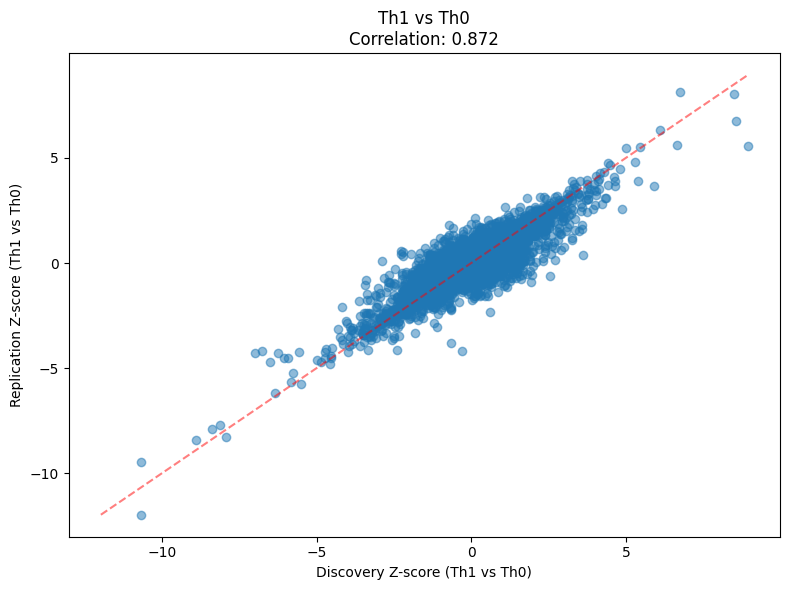


Th1 vs Th0 comparison:
Number of genes: 10000
Correlation coefficient: 0.872
Mean absolute difference in z-scores: 0.338


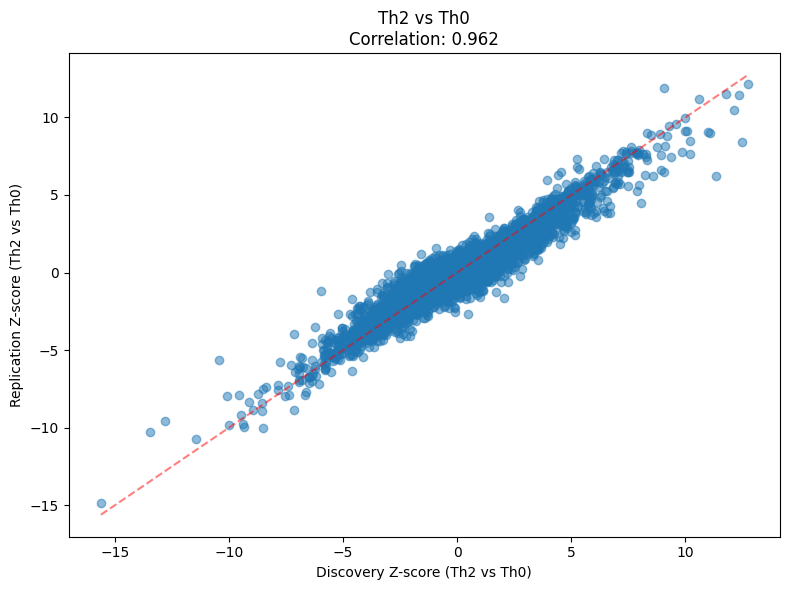


Th2 vs Th0 comparison:
Number of genes: 10000
Correlation coefficient: 0.962
Mean absolute difference in z-scores: 0.380


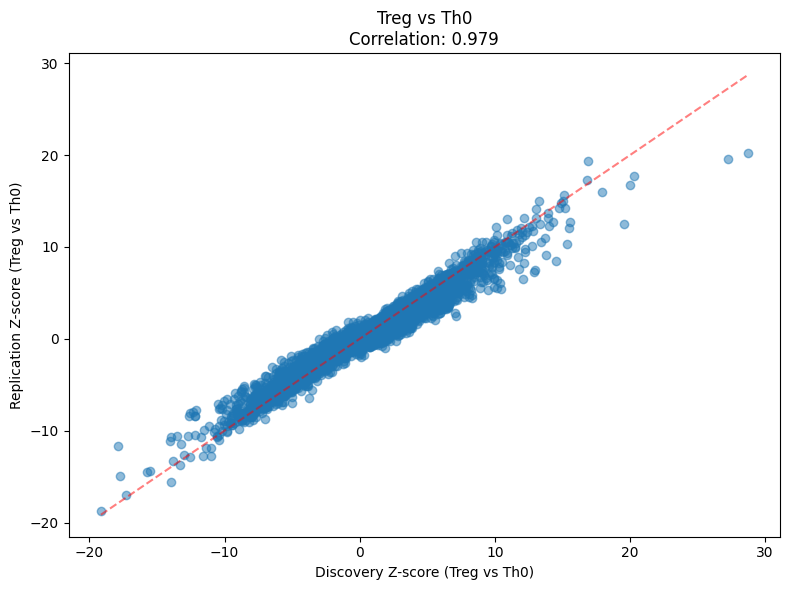


Treg vs Th0 comparison:
Number of genes: 10000
Correlation coefficient: 0.979
Mean absolute difference in z-scores: 0.520


In [6]:
all_results_df = pd.read_csv("results/discovery_polarization_DE_results.csv")
all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']

all_repl_results_df = pd.read_csv("results/replication_polarization_DE_results.csv")
all_repl_results_df['zscore'] = all_repl_results_df['log_fc']/all_repl_results_df['lfcSE']

# Compare z-scores between discovery and replication results for each condition
conditions = ['Th1', 'Th2', 'Treg']

for cond in conditions:
    # Get discovery and replication results for this condition
    disc_results = all_results_df[all_results_df['contrast'] == cond]
    repl_results = all_repl_results_df[all_repl_results_df['contrast'] == cond]
    
    # Merge on gene name to compare z-scores
    merged = pd.merge(disc_results, repl_results, 
                     on='variable', 
                     suffixes=('_disc', '_repl'))
    
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(merged['zscore_disc'], merged['zscore_repl'], alpha=0.5)
    plt.xlabel(f'Discovery Z-score ({cond} vs Th0)')
    plt.ylabel(f'Replication Z-score ({cond} vs Th0)')
    
    # Add correlation coefficient
    corr = merged['zscore_disc'].corr(merged['zscore_repl'])
    plt.title(f'{cond} vs Th0\nCorrelation: {corr:.3f}')
    
    # Add diagonal line
    min_val = min(merged['zscore_disc'].min(), merged['zscore_repl'].min())
    max_val = max(merged['zscore_disc'].max(), merged['zscore_repl'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print some summary statistics
    print(f"\n{cond} vs Th0 comparison:")
    print(f"Number of genes: {len(merged)}")
    print(f"Correlation coefficient: {corr:.3f}")
    print(f"Mean absolute difference in z-scores: {abs(merged['zscore_disc'] - merged['zscore_repl']).mean():.3f}")


NaNs encountered, dropping rows with NaNs
NaNs encountered, dropping rows with NaNs


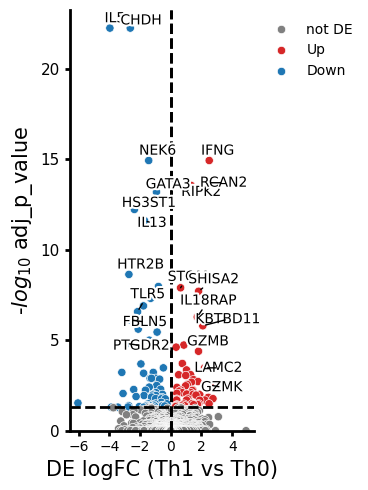

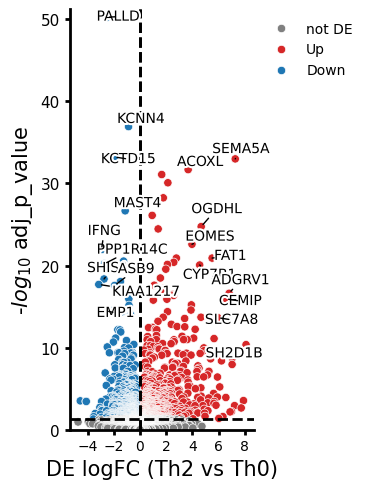

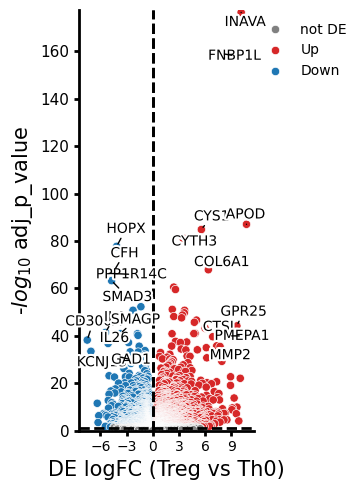

In [75]:
for res_df in result_dfs:
    p = res_df['contrast'].iloc[0]
    fig = model.plot_volcano(
        res_df, 
        log2fc_thresh=0, 
        return_fig=True, 
        x_label=f"DE logFC ({p} vs Th0)",
        to_label = 10

        )
    fig.tight_layout()  # Ensure title is visible
    fig.show()  # Explicitly show the figure

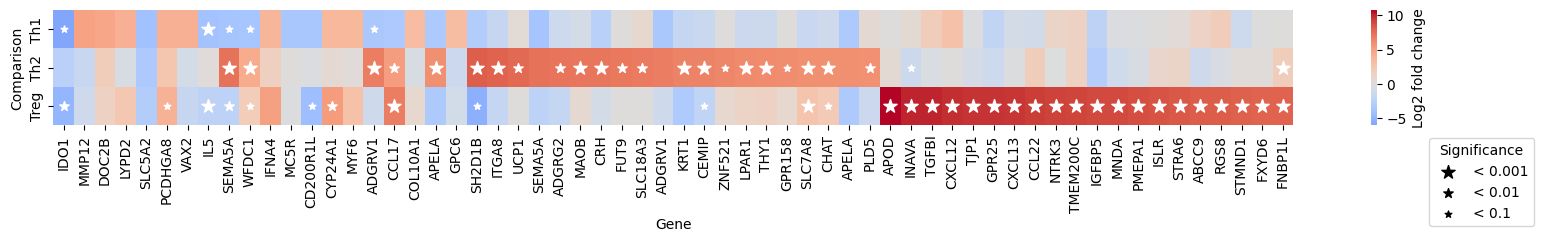

In [ ]:
all_results = pd.concat(result_dfs)
all_results['adj_p_value'] = all_results['adj_p_value'].fillna(1)
model.plot_multicomparison_fc(all_results, figsize=(20, 1.5), n_top_vars=20, xticklabels=True, x_label = "Gene", y_label='Comparison')

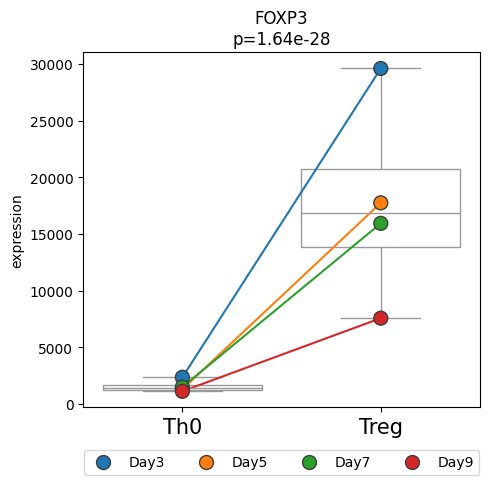

In [85]:
p = 'Treg'
model.plot_paired(
    pbulk_adata[pbulk_adata.obs['culture_condition'].isin(['Th0', p])], 
    results_df=all_results[(all_results.variable == 'FOXP3') & (all_results.contrast == p)], 
    n_top_vars=1, groupby="culture_condition", pairedby="timepoint")


<Axes: xlabel='contrast', ylabel='contrast'>

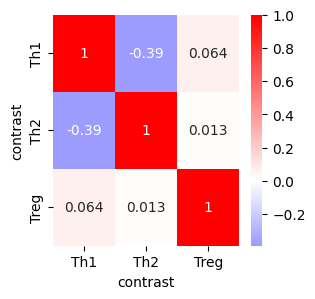

In [80]:
wide_results = all_results_df.pivot_table(index='variable', columns='contrast', values='zscore')
plt.figure(figsize=(3,3))
sns.heatmap(wide_results.corr(), annot=True, center=0, cmap='bwr')

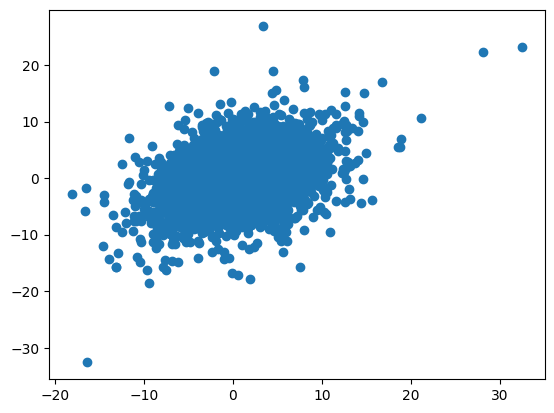

In [264]:
pearsonr(wide_results['Th1'] + wide_results['Treg'], wide_results['Th17'])
plt.scatter(wide_results['Th1'] + wide_results['Treg'], wide_results['Th17'])

## Load perturb-seq signatures

In [8]:
# Import utility functions from DE_analysis_utils.py
import sys
import os
sys.path.append(os.path.abspath('../3_DE_analysis'))
from DE_analysis_utils import get_DE_results_long


In [9]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/'
experiment_name = 'CD4iR1_Psomagen'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond
    # affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['MASH_lfsr'] < 0.05, axis=0)
    # adata_de.var[f'n_mash_signif_effects_{cond}'] = affected_gs_cond

adata_de.var_names = adata_de.var['gene_name'].values
adata_de.var_names

Index(['TSPAN6', 'DPM1', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC', 'NFYA',
       'STPG1', 'NIPAL3',
       ...
       'SMIM33', 'MSANTD7', 'SCO2', 'C2orf81', 'TBCE', 'ARHGAP11B', 'F8A1',
       'HOMEZ', 'ENSG00000290797', 'SOD2'],
      dtype='object', length=10079)

In [10]:
os.listdir(datadir + f'/DE_results_all_confounders/')

['DE_summary_stats_per_target.csv',
 'DE_shared_effects_jaccard.csv',
 'CD4iR1_Psomagen.merged_DE_results.h5ad',
 'DE_config.yaml',
 'tmp',
 'DE_shared_effects_jaccard.parquet']

In [11]:
# Load summary stats
DE_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
DE_stats = DE_stats[DE_stats['condition'] == 'Stim8hr']
keep_targets = DE_stats[ (DE_stats.n_total_de_genes > 1)].target_name.tolist()
print(len(keep_targets))

3861


In [12]:
k562_info = pd.read_csv('/mnt/oak/users/emma/data/wesvae-data/K562_gwps_info.csv')
keep_targets_k562 = k562_info[k562_info['Effect Category'] != 'Unperturbed'].perturbed_gene

In [ ]:
# K562 signatures as negative controls
k562_de = pd.read_table('/mnt/oak/users/mineto/workstation/K562_manuscript_upload/data/Perturbseq/geneLevel/limma_logFC_sum.txt', index_col=0)
k562_de.head()


## Fit model of target state from perturbations

In [3]:
from perturb2tissue_eval import *

In [4]:
def train_perturb2tissue_models(
    target_state, 
    all_results_df, 
    adata_de, 
    cond='Stim8hr',
    perturb_layer = 'zscore',
    ctrl_de=None, n_pcs=60, n_splits=5, n_repeats=1):
    """
    Train Perturb2Tissue models for a specific target state using CD4 cells and optionally K562 cells.
    
    Parameters:
    -----------
    target_state : str
        The target state to predict (e.g., 'Th1', 'Th2', 'Th17', 'Treg')
    all_results_df : pandas.DataFrame
        DataFrame containing DE results with 'variable', 'contrast', and 'zscore' columns
    adata_de : AnnData
        AnnData object containing DE results
    cond : str, default='Stim8hr'
        Culture condition to use for training
    ctrl_de : pandas.DataFrame, optional
        DataFrame containing K562 DE results. If None, only CD4 model will be trained
    n_pcs : int, default=60
        Number of principal components to use
    n_splits : int, default=5
        Number of cross-validation splits
    n_repeats : int, default=3
        Number of cross-validation repeats
        
    Returns:
    --------
    tuple
        If ctrl_de is provided: (p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs)
        If ctrl_de is None: (p2t_model, None, X_perturbs, y_target, common_gs)
    """
    print(f"Starting training for target state: {target_state}")
    
    # Get target state values
    y_target = all_results_df.pivot_table(index='variable', columns='contrast', values='zscore')[target_state]
    print(f"Initial target values shape: {y_target.shape}")

    # Find common genes
    common_gs = np.intersect1d(y_target.index, adata_de.var_names)
    print(f"Common genes between target and adata_de: {len(common_gs)}")

    if ctrl_de is not None:
        # Map gene IDs to gene names for K562 comparison
        common_gs_ids_df = adata_de[:, common_gs].var[['gene_ids', 'gene_name']]
        common_gs_ids = common_gs_ids_df[common_gs_ids_df.gene_ids.isin(ctrl_de.index)].gene_ids
        print(f"Common gene IDs with K562: {len(common_gs_ids)}")
        
        k562_de_test = ctrl_de[ctrl_de.index.isin(common_gs_ids)].copy()
        gene_id_to_name = dict(zip(common_gs_ids_df['gene_ids'], common_gs_ids_df['gene_name']))
        k562_de_test.index = [gene_id_to_name[gene_id] for gene_id in k562_de_test.index]
        common_gs = np.intersect1d(common_gs, k562_de_test.index)

    y_target = y_target.loc[common_gs]
    print(f"Number of common genes for {target_state}: {len(common_gs)}")

    # Get responses in stim cells
    print(f"Getting perturbation responses for condition: {cond}")
    X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                              ['target_contrast_gene_name'] + list(common_gs), 
                              layer=perturb_layer)
    X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
    print(f"Perturbation matrix shape: {X_perturbs.shape}")

    if ctrl_de is not None:
        # Find common perturbations between CD4 and K562
        common_perturbs = np.intersect1d(k562_de_test.columns, X_perturbs.columns)
        print(f"Common perturbations between CD4 and K562: {len(common_perturbs)}")
        X_perturbs = X_perturbs[common_perturbs]
        k562_de_test = k562_de_test[common_perturbs]
        k562_de_test_masked = k562_de_test.copy()
        mask = pd.DataFrame(False, index=k562_de_test_masked.index, columns=k562_de_test_masked.columns)
        for idx in k562_de_test_masked.index:
            if idx in k562_de_test_masked.columns:
                mask.loc[idx, idx] = True
        k562_de_test_masked = k562_de_test_masked.mask(mask)
        # Impute masked values with column means
        k562_de_test_masked = k562_de_test_masked.fillna(k562_de_test_masked.mean())
    
    # Mask effects in cis
    X_perturbs_masked = X_perturbs.copy()
    mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
    for idx in X_perturbs_masked.index:
        if idx in X_perturbs_masked.columns:
            mask.loc[idx, idx] = True
    X_perturbs_masked = X_perturbs_masked.mask(mask)
    # Impute masked values with column means
    X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())

    # Train model on CD4 cells
    print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
    p2t_model = Perturb2TissueModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
    p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{cond}_{target_state}')
    print(f"CD4 model training complete.")

    # Train model on K562 cells if provided
    p2t_model_k562 = None
    if ctrl_de is not None:
        print(f"Training K562 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
        p2t_model_k562 = Perturb2TissueModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
        p2t_model_k562.fit(k562_de_test_masked, y_target, model_id=f'K562_{target_state}')
        print(f"K562 model training complete.")
    
    print(f"Model training for {target_state} completed successfully")
    return p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs

def unpack_state_results(model_results, state):
    return {
        'p2t_model': model_results[state]['p2t_model'],
        'p2t_model_k562': model_results[state]['p2t_model_k562'],
        'X_perturbs': model_results[state]['X_perturbs'],
        'y_target': model_results[state]['y_target'],
        'common_gs': model_results[state]['common_gs']
    }




### Comparison with K562 data
Subsetting to common perturbations

In [7]:
model_results = {}

for target_state in ['Th1', "Th2", 'Treg']:
    p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = train_perturb2tissue_models(
        target_state, 
        all_results_df, 
        adata_de[adata_de.obs['target_contrast_gene_name'].isin(np.intersect1d(keep_targets, keep_targets_k562))], 
        ctrl_de=k562_de,
        cond='Stim8hr',
        perturb_layer='log_fc'
    )
    
    model_results[target_state] = {
        'p2t_model': p2t_model,
        'p2t_model_k562': p2t_model_k562,
        'X_perturbs': X_perturbs,
        'y_target': y_target,
        'common_gs': common_gs
    }


NameError: name 'adata_de' is not defined

In [153]:
# import pickle
# output_path = f"{datadir}/polarization_prediction_models_k562comparison.pkl"
# with open(output_path, 'wb') as f:
#     pickle.dump(model_results, f)

PicklingError: Can't pickle <class 'perturb2tissue_eval.Perturb2TissueModel'>: it's not the same object as perturb2tissue_eval.Perturb2TissueModel

In [52]:
# model_results_rest = {}

# for target_state in ['Th1', "Th2", 'Treg']:
#     p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = train_perturb2tissue_models(
#         target_state, 
#         all_results_df, 
#         adata_de[adata_de.obs['target_contrast_gene_name'].isin(keep_targets)], 
#         ctrl_de=k562_de,
#         cond='Rest'
#     )
    
#     # Store all outputs in the dictionary
#     model_results_rest[target_state] = {
#         'p2t_model': p2t_model,
#         'p2t_model_k562': p2t_model_k562,
#         'X_perturbs': X_perturbs,
#         'y_target': y_target,
#         'common_gs': common_gs
#     }


Starting training for target state: Th1
Initial target values shape: (9999,)
Common genes between target and adata_de: 6944
Common gene IDs with K562: 4064
Number of common genes for Th1: 4064
Getting perturbation responses for condition: Rest
Perturbation matrix shape: (4064, 6368)
Common perturbations between CD4 and K562: 4849
Training CD4 model with 60 PCs, 3 splits, 3 repeats
CD4 model training complete.
Training K562 model with 60 PCs, 3 splits, 3 repeats
K562 model training complete.
Model training for Th1 completed successfully
Starting training for target state: Th2
Initial target values shape: (9999,)
Common genes between target and adata_de: 6944
Common gene IDs with K562: 4064
Number of common genes for Th2: 4064
Getting perturbation responses for condition: Rest
Perturbation matrix shape: (4064, 6368)
Common perturbations between CD4 and K562: 4849
Training CD4 model with 60 PCs, 3 splits, 3 repeats
CD4 model training complete.
Training K562 model with 60 PCs, 3 splits, 3 

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 18.06413480521531
  model = cd_fast.enet_coordinate_descent_gram(
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343.25074514799417, tolerance: 17.49674882636336
  model = cd_fast.enet_coordinate_descent_gram(
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423.1932252675051, tolerance: 17.49674882636336
  model = cd_fast.enet_coordinate_descent_gram(
/home/emmadann/minif

K562 model training complete.
Model training for Treg completed successfully


/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1880.6028329871551, tolerance: 17.220847601670727
  model = cd_fast.enet_coordinate_descent_gram(
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 937.6956520302483, tolerance: 17.700829990012892
  model = cd_fast.enet_coordinate_descent_gram(
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1117.472352075023, tolerance: 16.33146397286903
  model = cd_fast.enet_coordinate_descent_gram(
/hom

In [239]:
# cond = 'Stim8hr'
# n_pcs = 60
# n_splits = 3
# n_repeats = 3
# common_perturbs = np.intersect1d(keep_targets, keep_targets_k562.values)
# X_perturbs_baseline = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
#                             ['target_contrast_gene_name'] + list(common_gs), 
#                             layer='baseMean')

# X_perturbs_baseline = X_perturbs_baseline.set_index('target_contrast_gene_name').T
# X_perturbs_baseline = X_perturbs_baseline[common_perturbs].mean(axis=1)
# X_perturbs_baseline = np.log10(X_perturbs_baseline.reset_index().set_index('index'))

# # Scale the baseline expression values to z-scores
# X_perturbs_baseline_scaled = (X_perturbs_baseline - X_perturbs_baseline.mean()) / X_perturbs_baseline.std()

# p2t_model_baseline = Perturb2TissueModel(pca_transform=False, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=True)
# p2t_model_baseline.fit(X_perturbs_baseline_scaled.loc[y_target.index], y_target, model_id=f'{cond}_{target_state}')

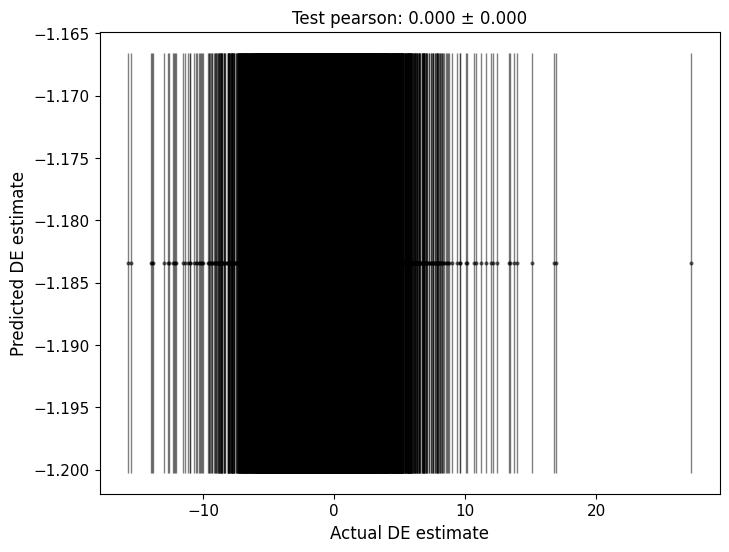

In [92]:
# fig = p2t_model.plot_prediction(X_perturbs, y_target, plot_metric='pearson')
# fig.show()
fig = p2t_model_baseline.plot_prediction(X_perturbs_baseline, y_target, plot_metric='pearson')
fig.show()

In [76]:
# cond = "Rest"
# target_state = 'Th2'
# X_perturbs_baseline = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
#                             ['target_contrast_gene_name'] + list(common_gs), 
#                             layer='baseMean')
# X_perturbs_baseline = X_perturbs_baseline.set_index('target_contrast_gene_name').T
# X_perturbs_baseline = X_perturbs_baseline[common_perturbs]
# X_perturbs_baseline = X_perturbs_baseline[common_perturbs].mean(axis=1)
# X_perturbs_baseline = X_perturbs_baseline

# y_baseline = all_results_df.pivot_table(index='variable', columns='contrast', values='baseMean')[target_state]
# y_baseline = y_baseline.loc[common_gs]

# from scipy.stats import pearsonr

# # Calculate correlation coefficient
# corr, p_value = pearsonr(np.log10(X_perturbs_baseline), np.log10(y_baseline))

# # Create scatter plot with correlation in title
# plt.scatter(X_perturbs_baseline, y_baseline)
# plt.yscale('log');plt.xscale('log');
# plt.title(f'Correlation: r = {corr:.3f}, p = {p_value:.3e}')

In [170]:
# import pickle
# output_path = f"{datadir}/polarization_prediction_models_k562comparison.pkl"
# with open(output_path, 'rb') as f:
#     model_results = pickle.load(f)

In [241]:
st = 'Th1'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
common_gs_ids_df = adata_de[:, common_gs].var[['gene_ids', 'gene_name']]
common_gs_ids = common_gs_ids_df.gene_ids

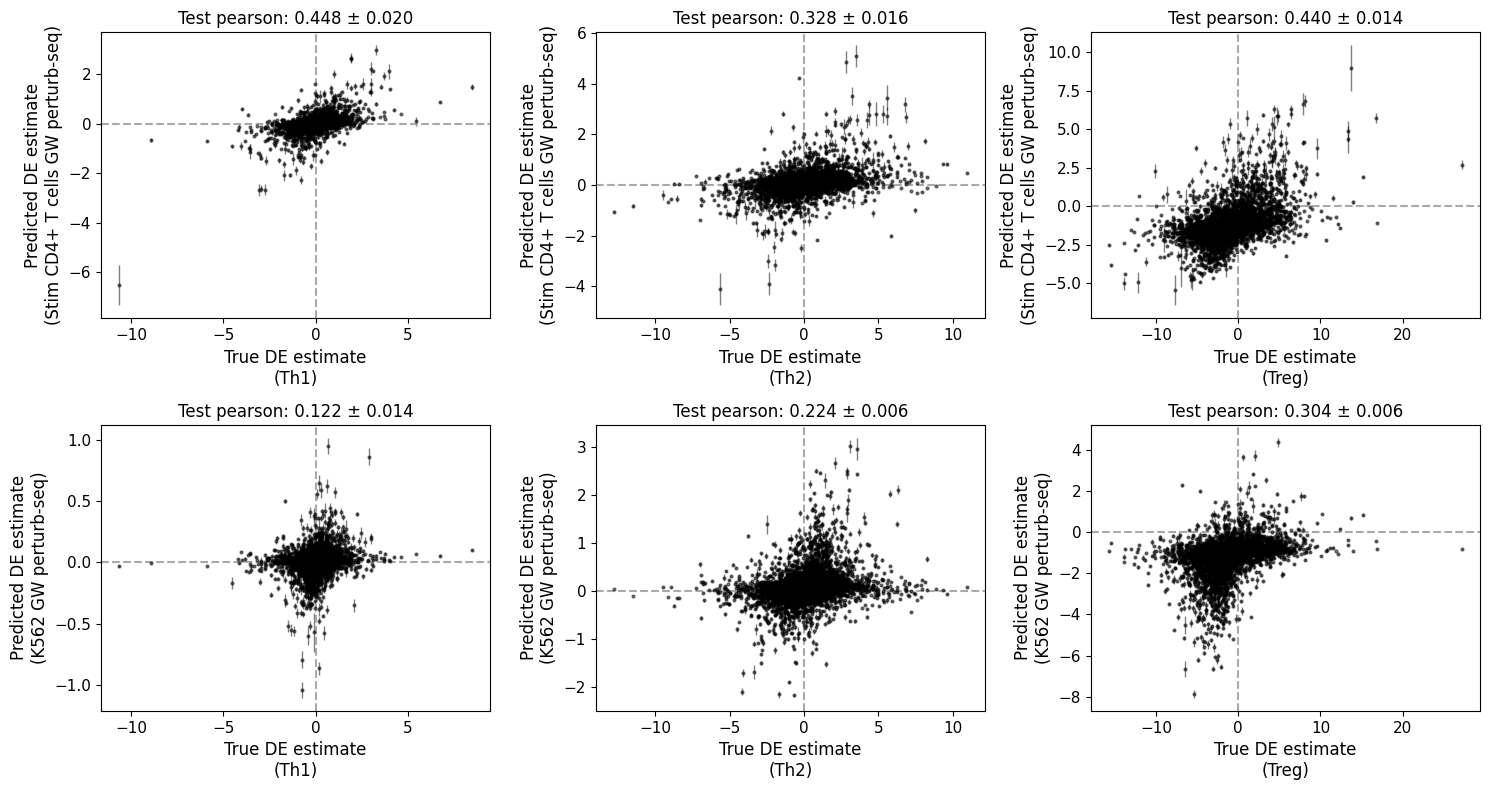

In [242]:
# Create a figure with subplots for all conditions
fig, axes = plt.subplots(2, len(model_results), figsize=(5*len(model_results), 8))

# Process each state
for i, st in enumerate(model_results.keys()):
    p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()

    k562_de_test = k562_de[k562_de.index.isin(common_gs_ids)].copy()
    gene_id_to_name = dict(zip(common_gs_ids_df['gene_ids'], common_gs_ids_df['gene_name']))
    k562_de_test.index = [gene_id_to_name[gene_id] for gene_id in k562_de_test.index]
    k562_de_test = k562_de_test.loc[X_perturbs.index, X_perturbs.columns]
    # Plot predictions for the main model in the top subplot
    p2t_model.plot_prediction(X_perturbs, y_target, plot_metric='pearson', ax=axes[0,i], return_ax=True)
    axes[0,i].set_ylabel('Predicted DE estimate\n(Stim CD4+ T cells GW perturb-seq)', fontsize=12)
    axes[0,i].set_xlabel(f'True DE estimate\n({st})', fontsize=12)
    axes[0,i].axhline(y=0, color='darkgrey', linestyle='--')
    axes[0,i].axvline(x=0, color='darkgrey', linestyle='--')

    # Plot predictions for the K562 model in the bottom subplot
    p2t_model_k562.plot_prediction(k562_de_test, y_target, plot_metric='pearson', ax=axes[1,i], return_ax=True)
    axes[1,i].set_ylabel('Predicted DE estimate\n(K562 GW perturb-seq)', fontsize=12)
    axes[1,i].set_xlabel(f'True DE estimate\n({st})', fontsize=12)
    axes[1,i].axhline(y=0, color='darkgrey', linestyle='--')
    axes[1,i].axvline(x=0, color='darkgrey', linestyle='--')

plt.tight_layout()
plt.show()


In [50]:
def eval_splits_on_repl(model, y_target, y_target_repl, state_name=None):
    """
    Calculate correlations between predictions and true values for each split of a model.
    
    Parameters
    ----------
    model : object
        Model object with get_prediction() and split_ixs attributes
    y_target : pd.Series
        Target values used for training
    y_target_repl : pd.Series
        Replicate target values to compare against
    state_name : str, optional
        Name of the state to include in output dataframe
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing correlation metrics for each split
    """
    # Get predictions for each split
    splits_pred = model.get_prediction(X_perturbs, return_splits=True)
    
    # Get test indices for each split
    test_indices = [x[1] for x in model.split_ixs]
    
    # Compare predictions to true values for each test split
    all_split_corrs = None
    for i, test_idx in enumerate(test_indices):
        # Get predictions for this split from the corresponding column
        test_pred = splits_pred.iloc[test_idx, i]
        test_true = y_target_repl.iloc[test_idx]
        test_input = y_target.iloc[test_idx]
        
        # Calculate correlation for this split
        corr = np.corrcoef(test_pred, test_true)[0,1]
        top_corr = np.corrcoef(test_input, test_true)[0,1]
        
        # Store correlation in dataframe
        split_corr_df = pd.DataFrame({
            'split': i,
            'correlation': corr,
            'upper_correlation': top_corr,
            'state': state_name
        }, index=[0])
        
        if all_split_corrs is None:
            all_split_corrs = split_corr_df
        else:
            all_split_corrs = pd.concat([all_split_corrs, split_corr_df])
            
    return all_split_corrs

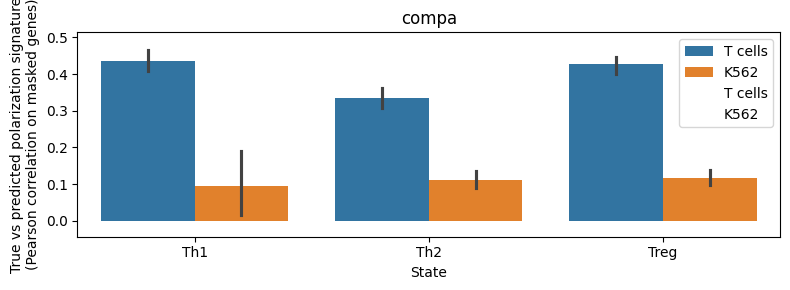

In [244]:
# Initialize empty dataframe to store all evaluation results
all_states_eval = pd.DataFrame()

# Loop through each state
for st in ['Th1', 'Th2', 'Treg']:
    # Get model results and predictions
    p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
    y_target_repl = all_repl_results_df.pivot_table(index='variable', columns='contrast', values='zscore')[st].loc[y_target.index]
    
    # Get evaluation results for both cell types
    eval_tcells = eval_splits_on_repl(p2t_model, y_target, y_target_repl, state_name=st)
    eval_k562 = eval_splits_on_repl(p2t_model_k562, y_target, y_target_repl, state_name=st)
    
    # Combine results for this state
    state_eval = pd.concat([eval_tcells, eval_k562])
    state_eval['cell_type'] = ['T cells'] * len(eval_tcells) + ['K562'] * len(eval_k562)
    
    # Add to overall results
    all_states_eval = pd.concat([all_states_eval, state_eval])

# Create single bar plot for all states
plt.figure(figsize=(8, 3))
sns.barplot(data=all_states_eval, x='state', y='correlation', hue='cell_type',
            palette={'T cells': 'tab:blue', 'K562': 'tab:orange'})
sns.stripplot(data=all_states_eval, x='state', y='correlation', hue='cell_type', dodge=True, color='black', marker='')
plt.title('compa')
plt.xlabel('State')
plt.ylabel('True vs predicted polarization signature\n(Pearson correlation on masked genes)')
plt.legend(title='Cell Type')

# Add horizontal line for mean upper correlation bound
# plt.axhline(y=all_states_eval['upper_correlation'].mean(), color='gray', linestyle='--',
#             label='Upper Bound')
plt.legend()

plt.tight_layout()
plt.show()


#### Retrain without comparison to K562

In [47]:
# Example usage for Th2
# Initialize dictionaries to store all outputs
model_results = {}

for target_state in ['Th1','Th2','Treg']:
    p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = train_perturb2tissue_models(
        target_state, 
        all_results_df, 
        adata_de[adata_de.obs['target_contrast_gene_name'].isin(keep_targets)], 
        ctrl_de=None,
        cond='Stim8hr',
        n_splits=5, n_repeats=1
    )
    
    # Store all outputs in the dictionary
    model_results[target_state] = {
        'p2t_model': p2t_model,
        'p2t_model_k562': p2t_model_k562,
        'X_perturbs': X_perturbs,
        'y_target': y_target,
        'common_gs': common_gs
    }


Starting training for target state: Th1
Initial target values shape: (10000,)
Common genes between target and adata_de: 6985
Number of common genes for Th1: 6985
Getting perturbation responses for condition: Stim8hr
Perturbation matrix shape: (6985, 3861)
Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for Th1 completed successfully
Starting training for target state: Th2
Initial target values shape: (10000,)
Common genes between target and adata_de: 6985
Number of common genes for Th2: 6985
Getting perturbation responses for condition: Stim8hr
Perturbation matrix shape: (6985, 3861)
Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for Th2 completed successfully
Starting training for target state: Treg
Initial target values shape: (10000,)
Common genes between target and adata_de: 6985
Number of common genes for Treg: 6985
Getting perturbation responses for condition: Stim8hr
Perturbation mat

In [192]:
# import pickle
# output_path = f"{datadir}/polarization_prediction_models.pkl"
# with open(output_path, 'wb') as f:
#     pickle.dump(model_results, f)

PicklingError: Can't pickle <class 'perturb2tissue_eval.Perturb2TissueModel'>: it's not the same object as perturb2tissue_eval.Perturb2TissueModel

In [7]:
# import pickle
# output_path = f"{datadir}/polarization_prediction_models.pkl"
# with open(output_path, 'rb') as f:
#     model_results = pickle.load(f)

In [246]:
model_results_rest = {}

for target_state in ['Th1']:
    p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = train_perturb2tissue_models(
        target_state, 
        all_results_df, 
        adata_de[adata_de.obs['target_contrast_gene_name'].isin(keep_targets)], 
        ctrl_de=None,
        cond='Rest',
        n_splits=3
    )
    
    # Store all outputs in the dictionary
    model_results_rest[target_state] = {
        'p2t_model': p2t_model,
        'p2t_model_k562': p2t_model_k562,
        'X_perturbs': X_perturbs,
        'y_target': y_target,
        'common_gs': common_gs
    }


Starting training for target state: Th1
Initial target values shape: (10000,)
Common genes between target and adata_de: 6985
Number of common genes for Th1: 6985
Getting perturbation responses for condition: Rest
Perturbation matrix shape: (6985, 3619)
Training CD4 model with 60 PCs, 3 splits, 1 repeats
CD4 model training complete.
Model training for Th1 completed successfully


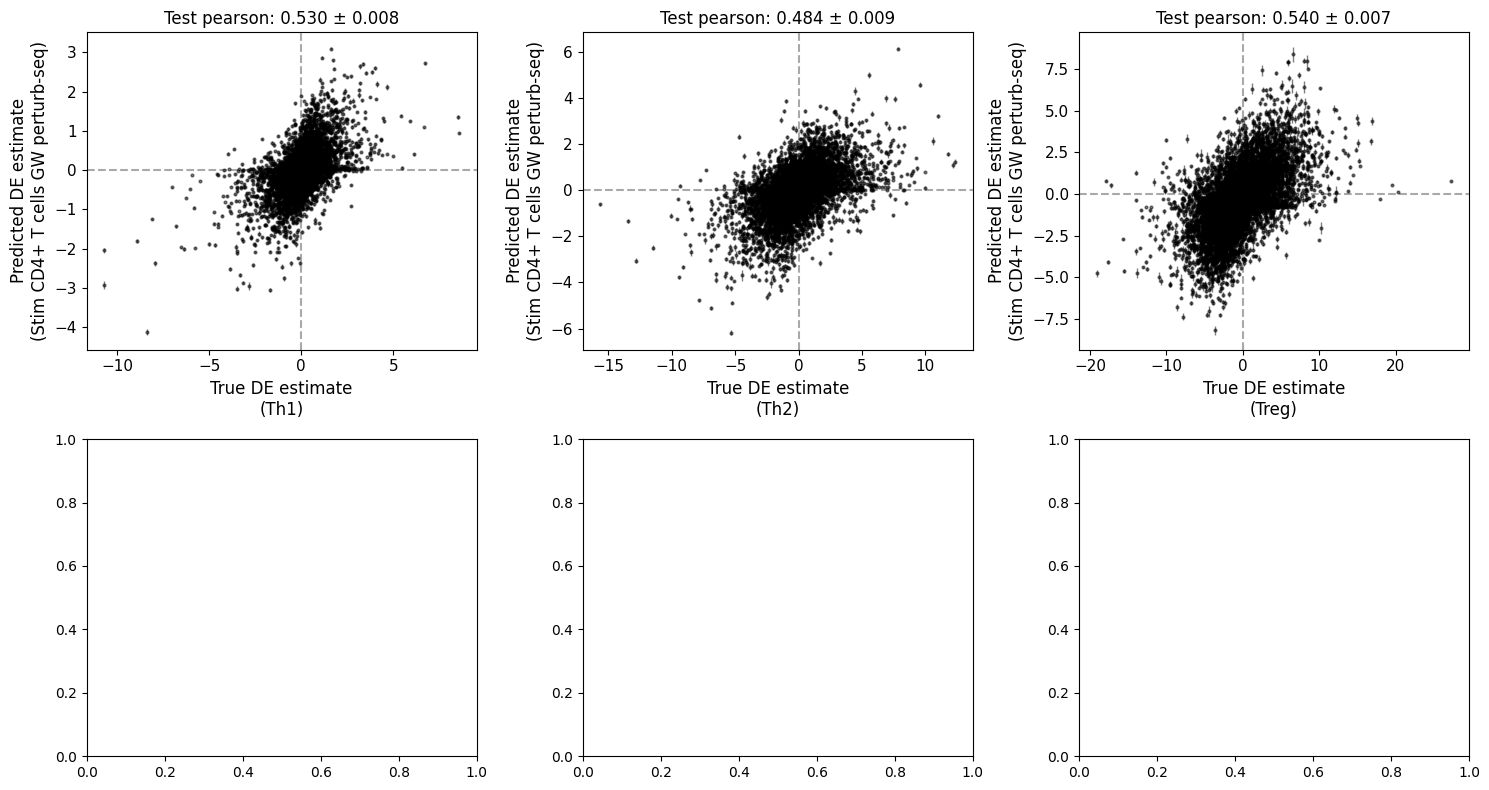

In [48]:
# Create a figure with subplots for all conditions
fig, axes = plt.subplots(2, len(model_results), figsize=(5*len(model_results), 8))

# Process each state
for i, st in enumerate(model_results.keys()):
    p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()

    # Plot predictions for the main model in the top subplot
    p2t_model.plot_prediction(X_perturbs, y_target, plot_metric='pearson', ax=axes[0,i], return_ax=True)
    axes[0,i].set_ylabel('Predicted DE estimate\n(Stim CD4+ T cells GW perturb-seq)', fontsize=12)
    axes[0,i].set_xlabel(f'True DE estimate\n({st})', fontsize=12)
    axes[0,i].axhline(y=0, color='darkgrey', linestyle='--')
    axes[0,i].axvline(x=0, color='darkgrey', linestyle='--')

    
plt.tight_layout()
plt.show()

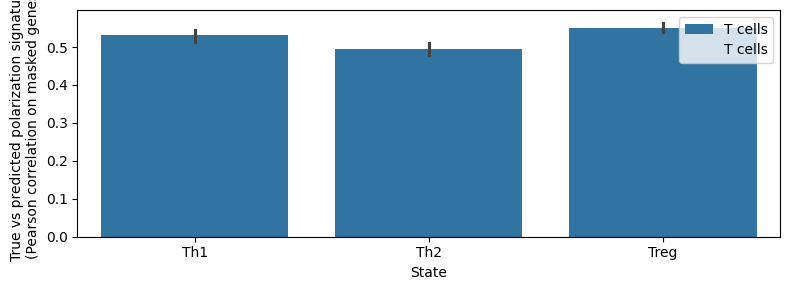

In [55]:
# Initialize empty dataframe to store all evaluation results
all_states_eval = pd.DataFrame()

# Loop through each state
for st in ['Th1', 'Th2', 'Treg']:
    # Get model results and predictions
    p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
    y_target_repl = all_repl_results_df.pivot_table(index='variable', columns='contrast', values='zscore')[st].loc[y_target.index]
    
    # Get evaluation results for both cell types
    eval_tcells = eval_splits_on_repl(p2t_model, y_target, y_target_repl, state_name=st)
    
    # Combine results for this state
    state_eval = pd.concat([eval_tcells])
    state_eval['cell_type'] = ['T cells'] * len(eval_tcells) 
    
    # Add to overall results
    all_states_eval = pd.concat([all_states_eval, state_eval])

# Create single bar plot for all states
plt.figure(figsize=(8, 3))
sns.barplot(data=all_states_eval, x='state', y='correlation', hue='cell_type',
            palette={'T cells': 'tab:blue', 'K562': 'tab:orange'})
sns.stripplot(data=all_states_eval, x='state', y='correlation', hue='cell_type', dodge=True, color='black', marker='')
plt.xlabel('State')
plt.ylabel('True vs predicted polarization signature\n(Pearson correlation on masked genes)')
plt.legend(title='Cell Type')

# Add horizontal line for mean upper correlation bound
# plt.axhline(y=all_states_eval['upper_correlation'].mean(), color='gray', linestyle='--',
#             label='Upper Bound')
plt.legend()

plt.tight_layout()
plt.show()


In [56]:
def get_splits_prediction(model, y_target, y_target_repl, state_name=None):
    """
    Save predictions and true values for test set of each split.
    
    Parameters
    ----------
    model : object
        Model object with get_prediction() and split_ixs attributes
    y_target : pd.Series
        Target values used for training
    y_target_repl : pd.Series
        Replicate target values to compare against
    state_name : str, optional
        Name of the state to include in output dataframe
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing predictions and true values for each test split
    """
    # Get predictions for each split
    splits_pred = model.get_prediction(X_perturbs, return_splits=True)
    
    # Get test indices for each split
    test_indices = [x[1] for x in model.split_ixs]
    
    # Store predictions and true values for each test split
    all_split_data = None
    for i, test_idx in enumerate(test_indices):
        # Get predictions and true values for this split
        test_pred = splits_pred.iloc[test_idx, i]
        test_true = y_target_repl.iloc[test_idx]
        test_input = y_target.iloc[test_idx]
        
        # Create dataframe for this split
        split_df = pd.DataFrame({
            'split': i,
            'gene': test_pred.index,
            'prediction': test_pred.values,
            'true_value': test_true.values,
            'input_value': test_input.values,
            'state': state_name
        })
        
        if all_split_data is None:
            all_split_data = split_df
        else:
            all_split_data = pd.concat([all_split_data, split_df])
            
    return all_split_data
    


/tmp/ipykernel_3179328/2398761968.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_correlations = all_split_data.groupby(['state', 'split', 'base_mean_bin']).apply(
/tmp/ipykernel_3179328/2398761968.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_correlations = all_split_data.groupby(['state', 'split', 'base_mean_bin']).apply(
/tmp/ipykernel_3179328/2398761968.py:25: DeprecationWarning:

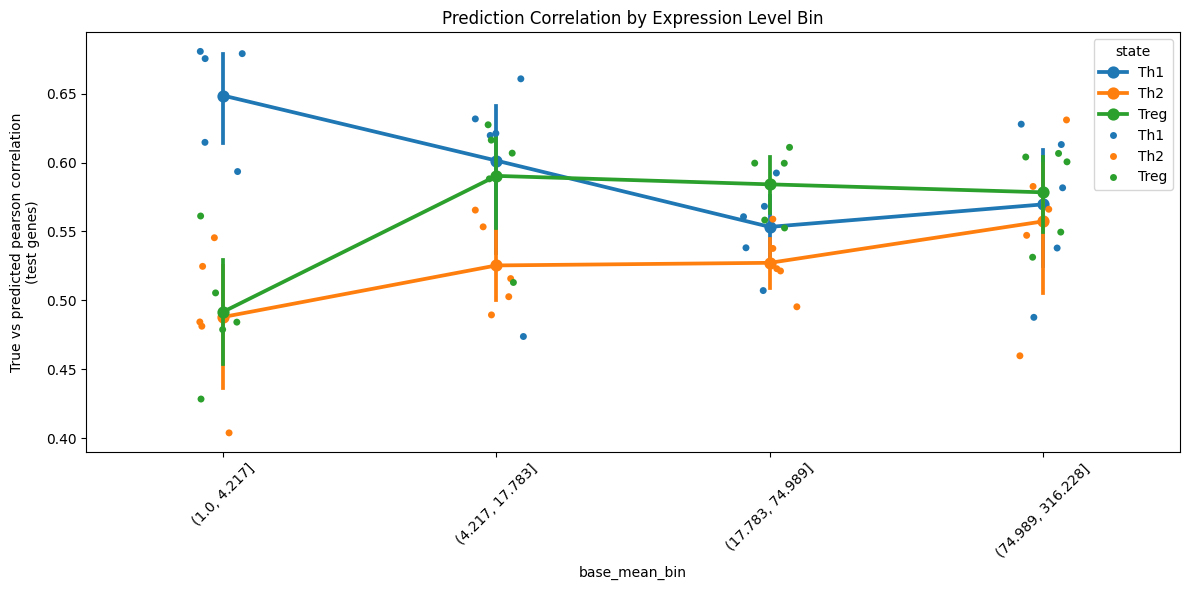

In [57]:
# Initialize empty dataframe to store all correlations
all_correlations = pd.DataFrame()

# Loop through each state
for st in ['Th1', 'Th2', 'Treg']:
    # Get model results and predictions for this state
    p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
    y_target_repl = all_repl_results_df.pivot_table(index='variable', columns='contrast', values='zscore')[st].loc[y_target.index]
    all_split_data = get_splits_prediction(p2t_model, y_target, y_target_repl, state_name=st)
    
    # Get base mean expression values
    base_mean = sc.get.var_df(adata_de[adata_de.obs['culture_condition'] == 'Stim8hr'], 
                             adata_de.obs_names[0], 
                             layer='baseMean')[adata_de.obs_names[0]]
    
    # Merge base mean values and create bins
    all_split_data = all_split_data.merge(base_mean.to_frame('base_mean'), 
                                         left_on='gene', 
                                         right_index=True)
    all_split_data['log10_base_mean'] = np.log10(all_split_data['base_mean'])
    bins = np.logspace(0, 2.5, 5)  # Creates bins from 10^0 to 10^4
    all_split_data['base_mean_bin'] = pd.cut(all_split_data['base_mean'], bins=bins)
    
    # Compute correlations for this state
    state_correlations = all_split_data.groupby(['state', 'split', 'base_mean_bin']).apply(
        lambda x: pd.Series({
            'correlation': x['prediction'].corr(x['true_value']),
            'n_genes': len(x)
        })
    ).reset_index()
    
    # Add to overall correlations
    all_correlations = pd.concat([all_correlations, state_correlations])

# Final correlations dataframe contains results for all states
correlations = all_correlations

# Optional: Create a summary plot
plt.figure(figsize=(12, 6))
sns.pointplot(data=correlations, x='base_mean_bin', y='correlation', hue='state')
sns.stripplot(data=correlations, x='base_mean_bin', y='correlation', hue='state')
plt.xticks(rotation=45)
plt.title('Prediction Correlation by Expression Level Bin')
plt.ylabel('True vs predicted pearson correlation\n(test genes)')
plt.tight_layout()

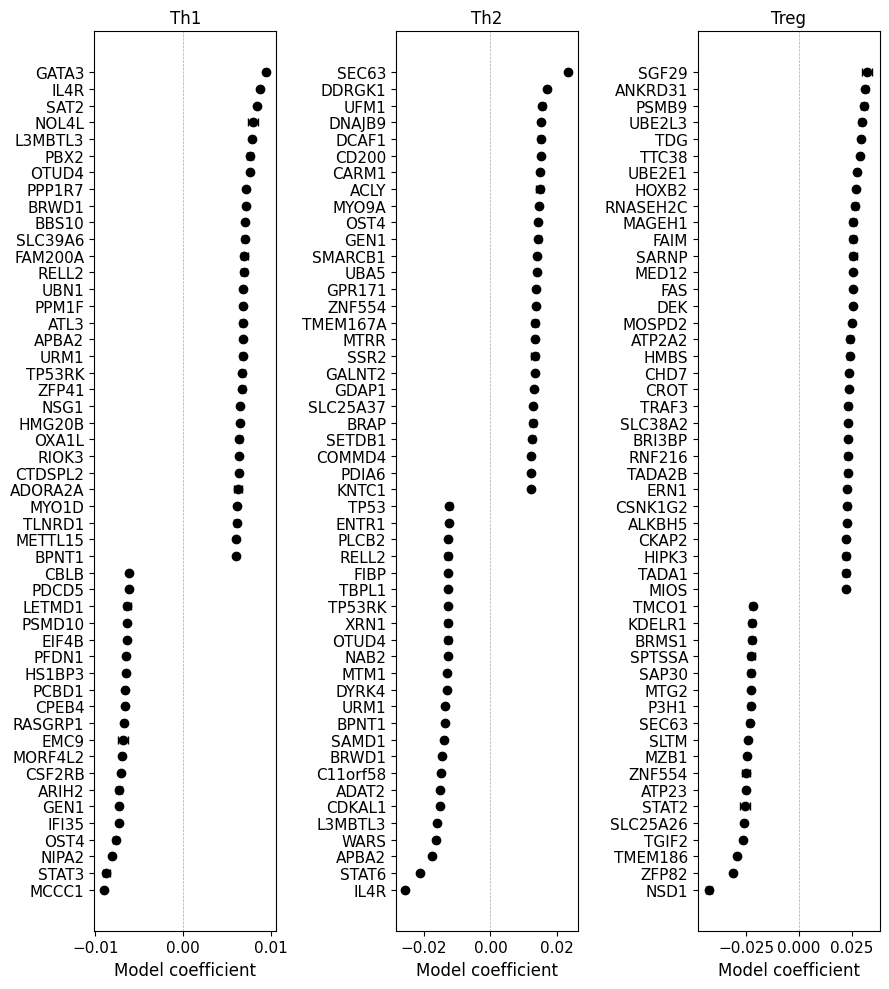

In [58]:
# Create a figure with subplots for all states in one row
fig, axes = plt.subplots(1, len(model_results), figsize=(3*len(model_results), 10))

# Ensure axes is always a list even if there's only one state
if len(model_results) == 1:
    axes = [axes]

# Plot coefficients for each state in its own subplot
for i, (st, ax) in enumerate(zip(model_results.keys(), axes)):
    p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
    p2t_model.plot_coefs(top_n=50, ax=ax, return_ax=True, show_labels=True)
    ax.set_title(st)

plt.tight_layout()

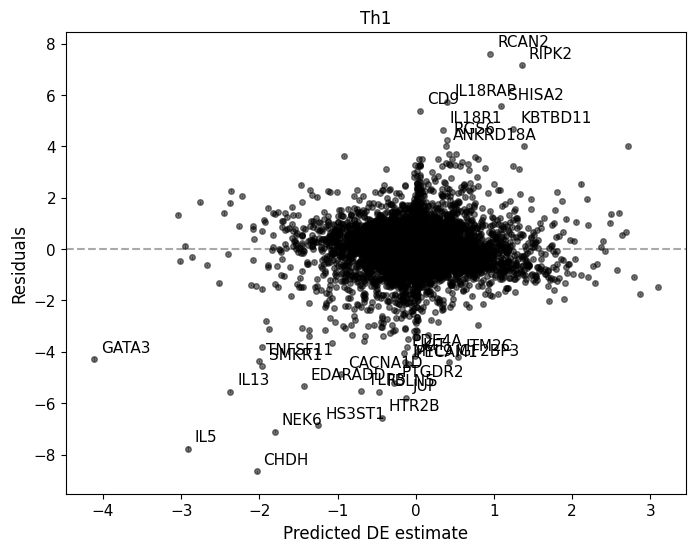

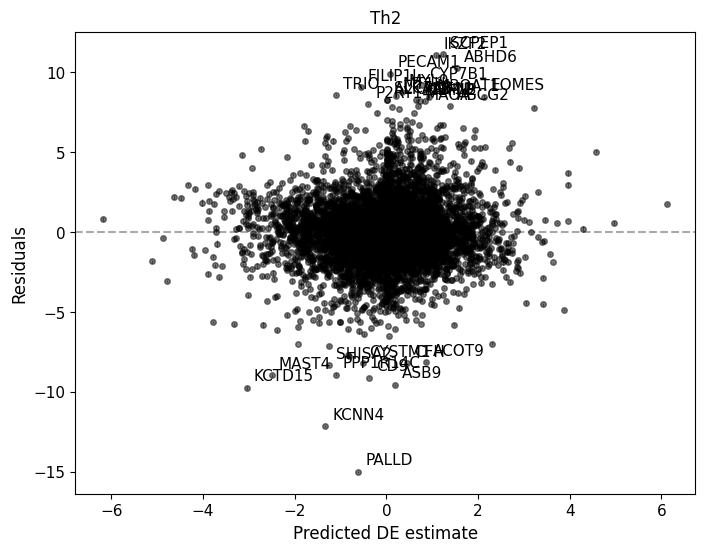

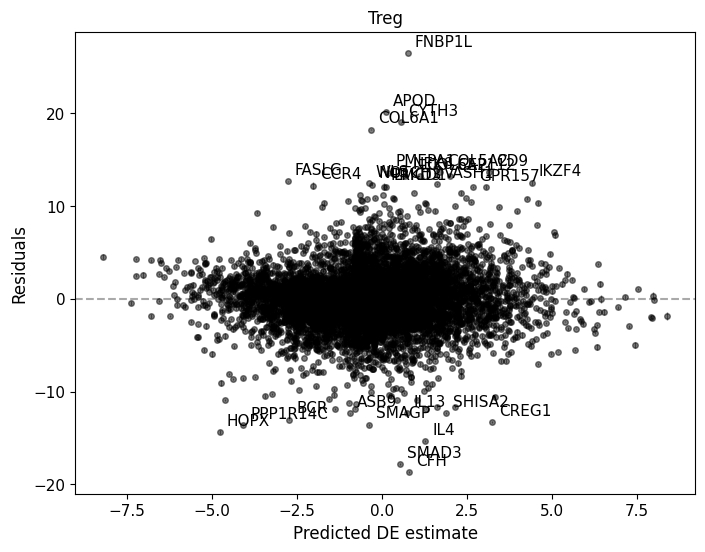

In [59]:
for i, (st) in enumerate(model_results.keys()):
    p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
    pl = p2t_model.plot_residuals(X_perturbs, y_target, annotate_top_n=30)
    plt.title(st)


In [60]:
all_coefs = pd.DataFrame()
for i, st in enumerate(model_results.keys()):
    p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
    pt_coefs = p2t_model.get_coefs()
    pt_coefs['state'] = st
    all_coefs = pd.concat([all_coefs, pt_coefs])


In [27]:
all_coefs

coef_mean  coef_sem state
TRIO     0.000502  0.000090   Th1
THAP3   -0.001125  0.000267   Th1
KDM4A    0.001897  0.000167   Th1
TIMM21   0.000112  0.000172   Th1
PIBF1    0.001664  0.000163   Th1
...           ...       ...   ...
MPLKIP  -0.002829  0.000961  Treg
CES2     0.004942  0.000541  Treg
JPT1     0.000707  0.001411  Treg
IGF2R    0.004402  0.000820  Treg
FAN1    -0.002762  0.001202  Treg

[11583 rows x 3 columns]

In [63]:
import gseapy as gp

def parse_gene_sets(filename):
   gene_sets = {}
   with open(filename, 'r') as f:
       for line in f:
           terms = line.strip().split('\t')
           gene_sets[terms[0]] = terms[2:]
   return gene_sets

OAKPATH = '/mnt/oak/'
KEGG_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data//KEGG_2019_Human.txt')
GO_BP_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data/GO_Biological_Process_2023.txt')
GENESETS = {**KEGG_sets, **GO_BP_sets}
# [x for x in GENESETS.keys() if "Th2" in x]

th12_diff_set = np.intersect1d(GENESETS['Th1 and Th2 cell differentiation'], coefs_wide.index)

([Text(0.009094480648108342, -0.004979767167574388, 'GATA3'),
  Text(0.009522746153175629, -0.023783891289465113, 'IL4R'),
  Text(0.0007320617752972856, 0.010861438840422913, 'STAT1'),
  Text(0.0004711083287178893, 0.005400023415888064, 'IFNGR1'),
  Text(-0.0023856219275844408, 0.0008460386045128152, 'TBX21'),
  Text(0.006498463245733615, -0.019862208902377776, 'STAT6'),
  Text(-0.004954295356208099, -0.002431209747085411, 'RPTOR'),
  Text(0.002890721438441027, -0.0007592405325036883, 'RUNX3'),
  Text(0.005568378879989644, 0.007666278216336697, 'BACH2')],
 [Text(0.009094480648108342, -0.004979767167574388, ''),
  Text(0.0004711083287178893, 0.005400023415888064, ''),
  Text(-0.0023856219275844408, 0.0008460386045128152, ''),
  Text(-0.004954295356208099, -0.002431209747085411, '')])

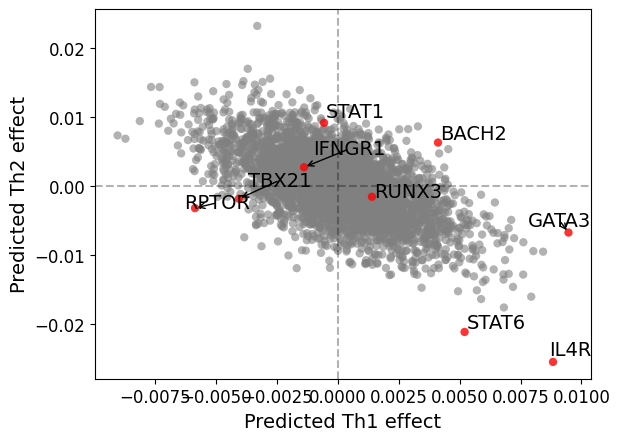

In [65]:
coefs_wide = all_coefs.pivot(columns='state', values='coef_mean')

known_regulators = [
    'GATA3', 'IL4R', 'STAT1', 'IFNGR1', 'IKFZ1', 
    'STAT4', 'TBX21', "STAT6", "RPTOR", 'RUNX3', 'BACH2'
]
# known_regulators = th12_diff_set

# Create base scatter plot for non-regulator genes
non_regulators = coefs_wide[~coefs_wide.index.isin(known_regulators)]
ax = sns.scatterplot(data=non_regulators, x='Th1', y='Th2', color='grey', alpha=0.6, edgecolor='none')

# Add scatter points for known regulators in red
regulators = coefs_wide[coefs_wide.index.isin(known_regulators)]
sns.scatterplot(data=regulators, x='Th1', y='Th2', color='red', alpha=0.8, edgecolor='none', ax=ax)

# Add dotted lines at x=0 and y=0
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.3)

# Set larger font sizes for axis labels and ticks
ax.set_xlabel('Predicted Th1 effect', fontsize=14)
ax.set_ylabel('Predicted Th2 effect', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add annotations for known regulators using adjustText
from adjustText import adjust_text
texts = []
for gene in known_regulators:
    if gene in coefs_wide.index:
        texts.append(ax.text(coefs_wide.loc[gene, 'Th1'], 
                           coefs_wide.loc[gene, 'Th2'],
                           gene,
                           fontsize=14))

# Adjust text positions to avoid overlaps
adjust_text(texts, 
           arrowprops=dict(arrowstyle='->', color='black', lw=1.0),
           expand_points=(1.5, 1.5))

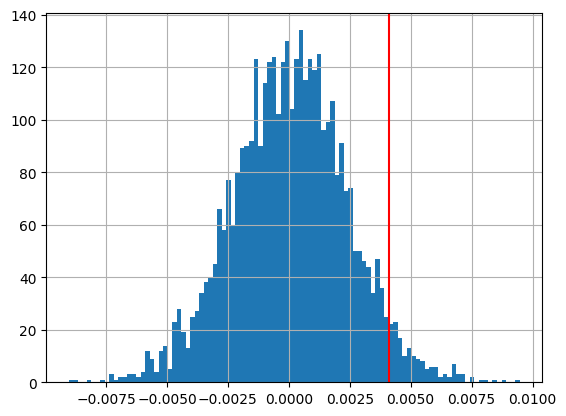

In [69]:
coefs_wide['Th1'].hist(bins=100);
plt.axvline(coefs_wide.loc['BACH2','Th1'], color='red')

In [170]:
st = 'Treg'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
    
coefs_df = p2t_model.get_coefs()
r2_df = p2t_model.get_r2(X_perturbs, y_target)

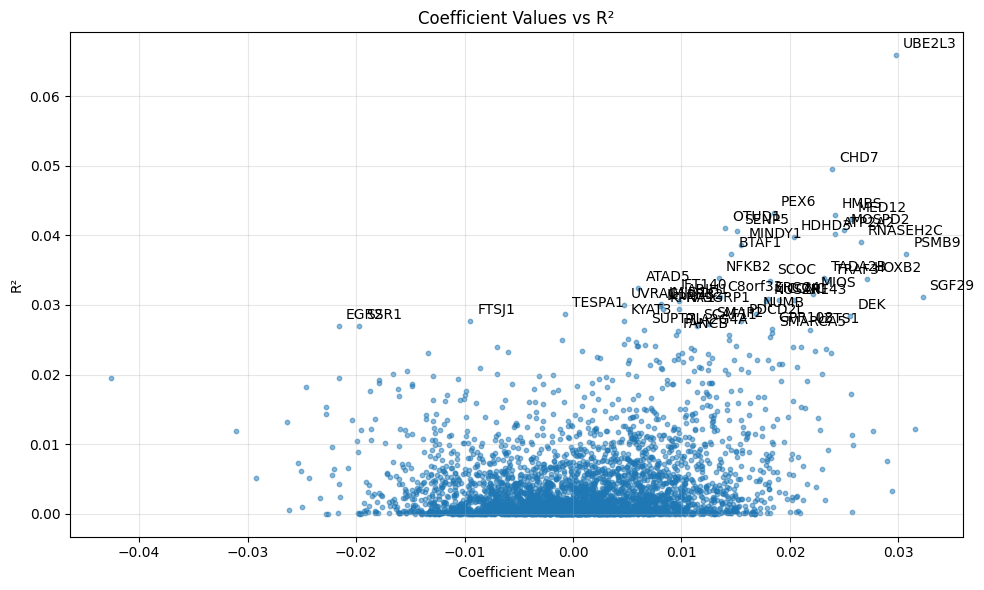

In [171]:
pt_coefs = pd.concat([coefs_df, r2_df], axis=1).astype('float')
# Create scatter plot of coefficients vs r2
plt.figure(figsize=(10, 6))
plt.scatter(pt_coefs['coef_mean'], pt_coefs['r2'], alpha=0.5, s=10)

# Get top 10 genes by absolute coefficient value
top_coefs = pt_coefs['r2'].nlargest(50).index

# Add annotations for top coefficient genes
for gene in top_coefs:
    plt.annotate(gene, 
                (pt_coefs.loc[gene, 'coef_mean'], pt_coefs.loc[gene, 'r2']),
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Coefficient Mean')
plt.ylabel('R²')
plt.title('Coefficient Values vs R²')
plt.grid(True, alpha=0.3)
plt.tight_layout()


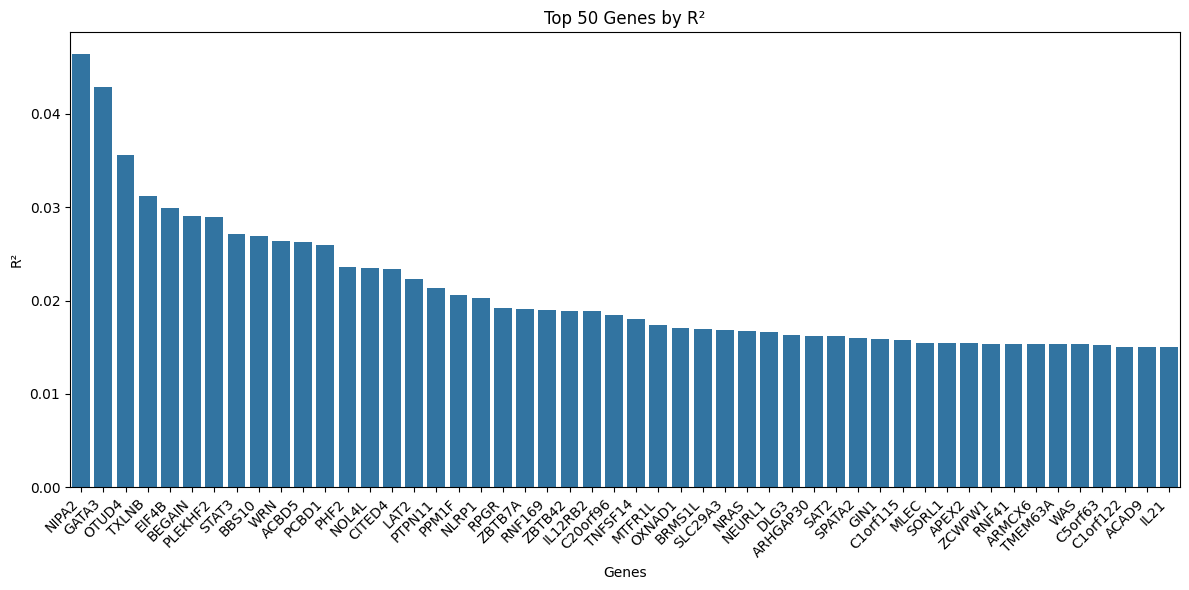

In [150]:
plt.figure(figsize=(12, 6))
sns.barplot(x=r2_top.index.tolist(), y=r2_top['r2'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genes')
plt.ylabel('R²')
plt.title('Top 50 Genes by R²')
plt.tight_layout()

In [132]:

g = 'GATA3'
st = 'Th1'

p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
pt_coefs = p2t_model.get_coefs()

# Initialize empty dataframe to store r2 values
r2_df = pd.DataFrame(index=X_perturbs.columns, columns=['r2'])

# Calculate r2 for each column
for col in X_perturbs.columns:
    # Get perturbation effects for this gene
    X_g = X_perturbs[col]
    # Mask self-perturbation and fill with mean
    X_g = X_g.mask(X_g.index == col).fillna(X_g.mean())
    # Calculate predictions using coefficients
    pred_from_g = X_g * pt_coefs['coef_mean'].loc[col]
    # Calculate correlation and r2
    corr, _ = scipy.stats.pearsonr(pred_from_g, y_target)
    r2_df.loc[col, 'r2'] = corr**2

# Sort by r2 values
r2_df = r2_df.sort_values('r2', ascending=False)
r2_df

r2
target_contrast_gene_name          
NIPA2                      0.046418
GATA3                      0.042888
OTUD4                      0.035552
TXLNB                      0.031241
EIF4B                      0.029963
...                             ...
GDF9                            0.0
AHCYL1                          0.0
CNOT6L                          0.0
IQCC                            0.0
ARF1                            0.0

[3861 rows x 1 columns]

<Axes: xlabel='coef_mean', ylabel='r2'>

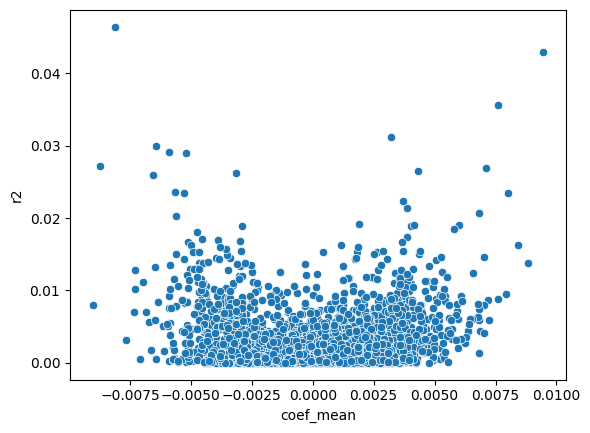

In [ ]:
pt_coefs['r2'] = r2_df['r2']
sns.scatterplot(data=pt_coefs, x='coef_mean', y='r2')

In [139]:
pt_coefs.sort_values('r2', ascending=False)[0:40]

coef_mean  coef_sem        r2
NIPA2     -0.008121  0.000211  0.046418
GATA3      0.009467  0.000254  0.042888
OTUD4      0.007609  0.000096  0.035552
TXLNB      0.003214  0.000244  0.031241
EIF4B     -0.006426  0.000105  0.029963
BEGAIN    -0.005919  0.000239  0.029107
PLEKHF2   -0.005194  0.000255  0.028973
STAT3     -0.008712  0.000355  0.027131
BBS10      0.007118  0.000190  0.026897
WRN        0.004310  0.000237  0.026432
ACBD5     -0.003156  0.000218  0.026247
PCBD1     -0.006560  0.000235  0.025934
PHF2      -0.005640  0.000139   0.02365
NOL4L      0.008025  0.000598  0.023486
CITED4    -0.005288  0.000129  0.023396
LAT2       0.003685  0.000347  0.022288
PTPN11     0.003877  0.000293  0.021394
PPM1F      0.006842  0.000262  0.020645
NLRP1     -0.005625  0.000343  0.020324
RPGR       0.001877  0.000137  0.019173
ZBTB7A     0.004173  0.000062  0.019091
RNF169     0.005991  0.000149  0.019047
ZBTB42    -0.002919  0.000256  0.018915
IL12RB2    0.004046  0.000177  0.018857
C20orf96   0.005813  0.000245  0.018496
TNFSF14   -0.004759  0.000040   0.01805
MTFR1L     0.003853  0.000133  0.017373
OXNAD1    -0.004527  0.000256  0.017117
BRMS1L    -0.003904  0.000166  0.017009
SLC29A3   -0.003002  0.000279  0.016885
NRAS       0.003669  0.000405  0.016737
NEURL1    -0.005107  0.000283   0.01666
DLG3       0.001173  0.000282  0.016294
ARHGAP30  -0.004986  0.000245  0.016259
SAT2       0.008425  0.000105  0.016226
SPATA2     0.001873  0.000182  0.015965
GIN1      -0.003789  0.000174  0.015928
C1orf115  -0.003541  0.000092  0.015733
MLEC      -0.002960  0.000343  0.015472
SORL1      0.004396  0.000166  0.015468

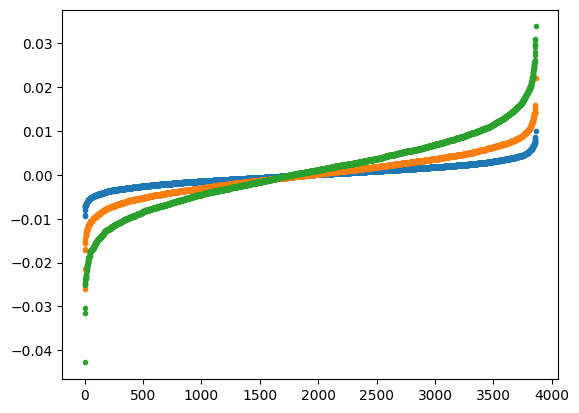

In [408]:
plt.plot(coefs_wide['Th1'].sort_values().values, '.')
plt.plot(coefs_wide['Th2'].sort_values().values, '.')
plt.plot(coefs_wide['Treg'].sort_values().values, '.')

In [251]:
# Normalize each row to sum to 1
coefs_wide_norm = coefs_wide.apply(lambda x: x - x.min(), axis=1)
# Get top 20 absolute values for each column and save in a list
top_genes_list = []
for col in coefs_wide_norm.columns:
    # Get absolute values and sort
    abs_values = coefs_wide_norm[col].abs().sort_values(ascending=False)
    # Get top 20 gene names and values
    top_20 = [gene for gene in abs_values.head(50).index]
    top_genes_list.extend(top_20)

top_genes_list = list(set(top_genes_list))


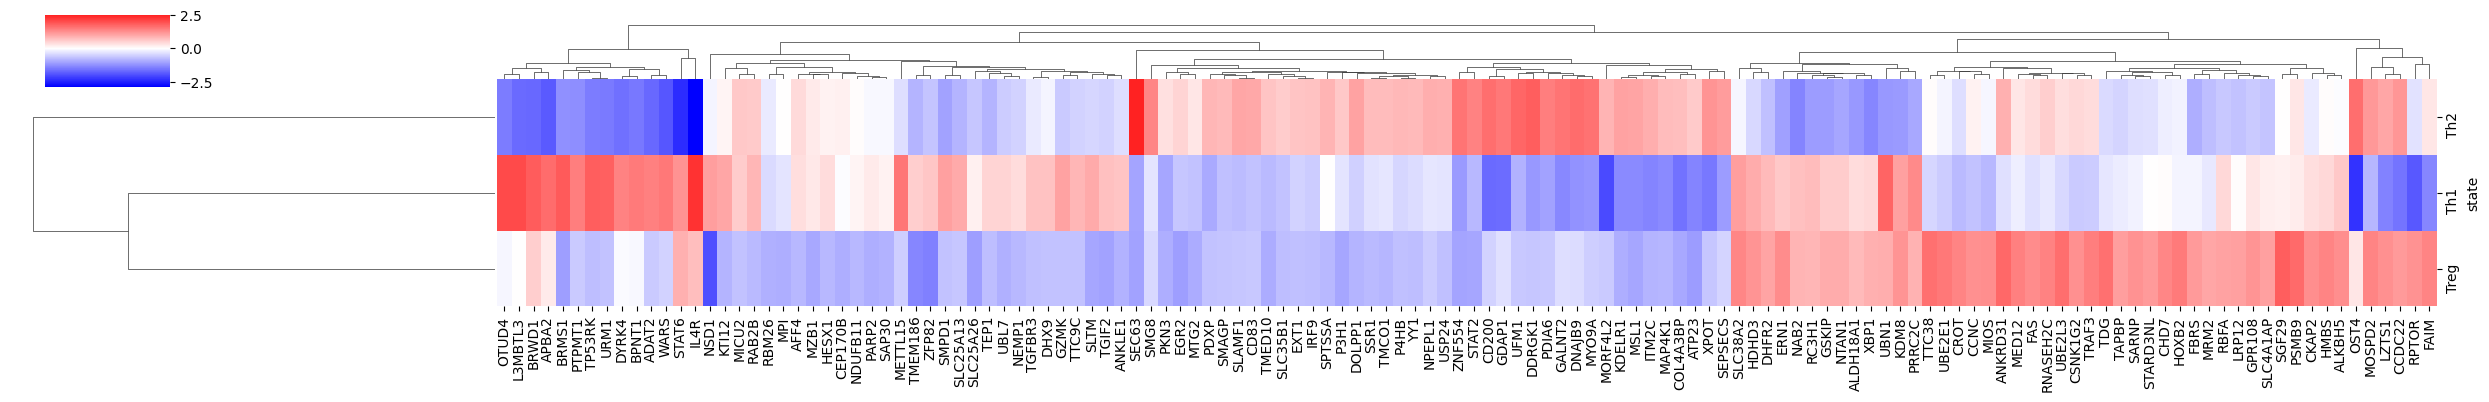

In [259]:
sns.clustermap(coefs_wide.loc[top_genes_list].T, center=0, cmap='bwr', figsize=(25,4), xticklabels=True, z_score=False)

Text(0.5, 1.0, 'Effect of Low Regulators on Most Affected Genes')

<Figure size 1500x2000 with 0 Axes>

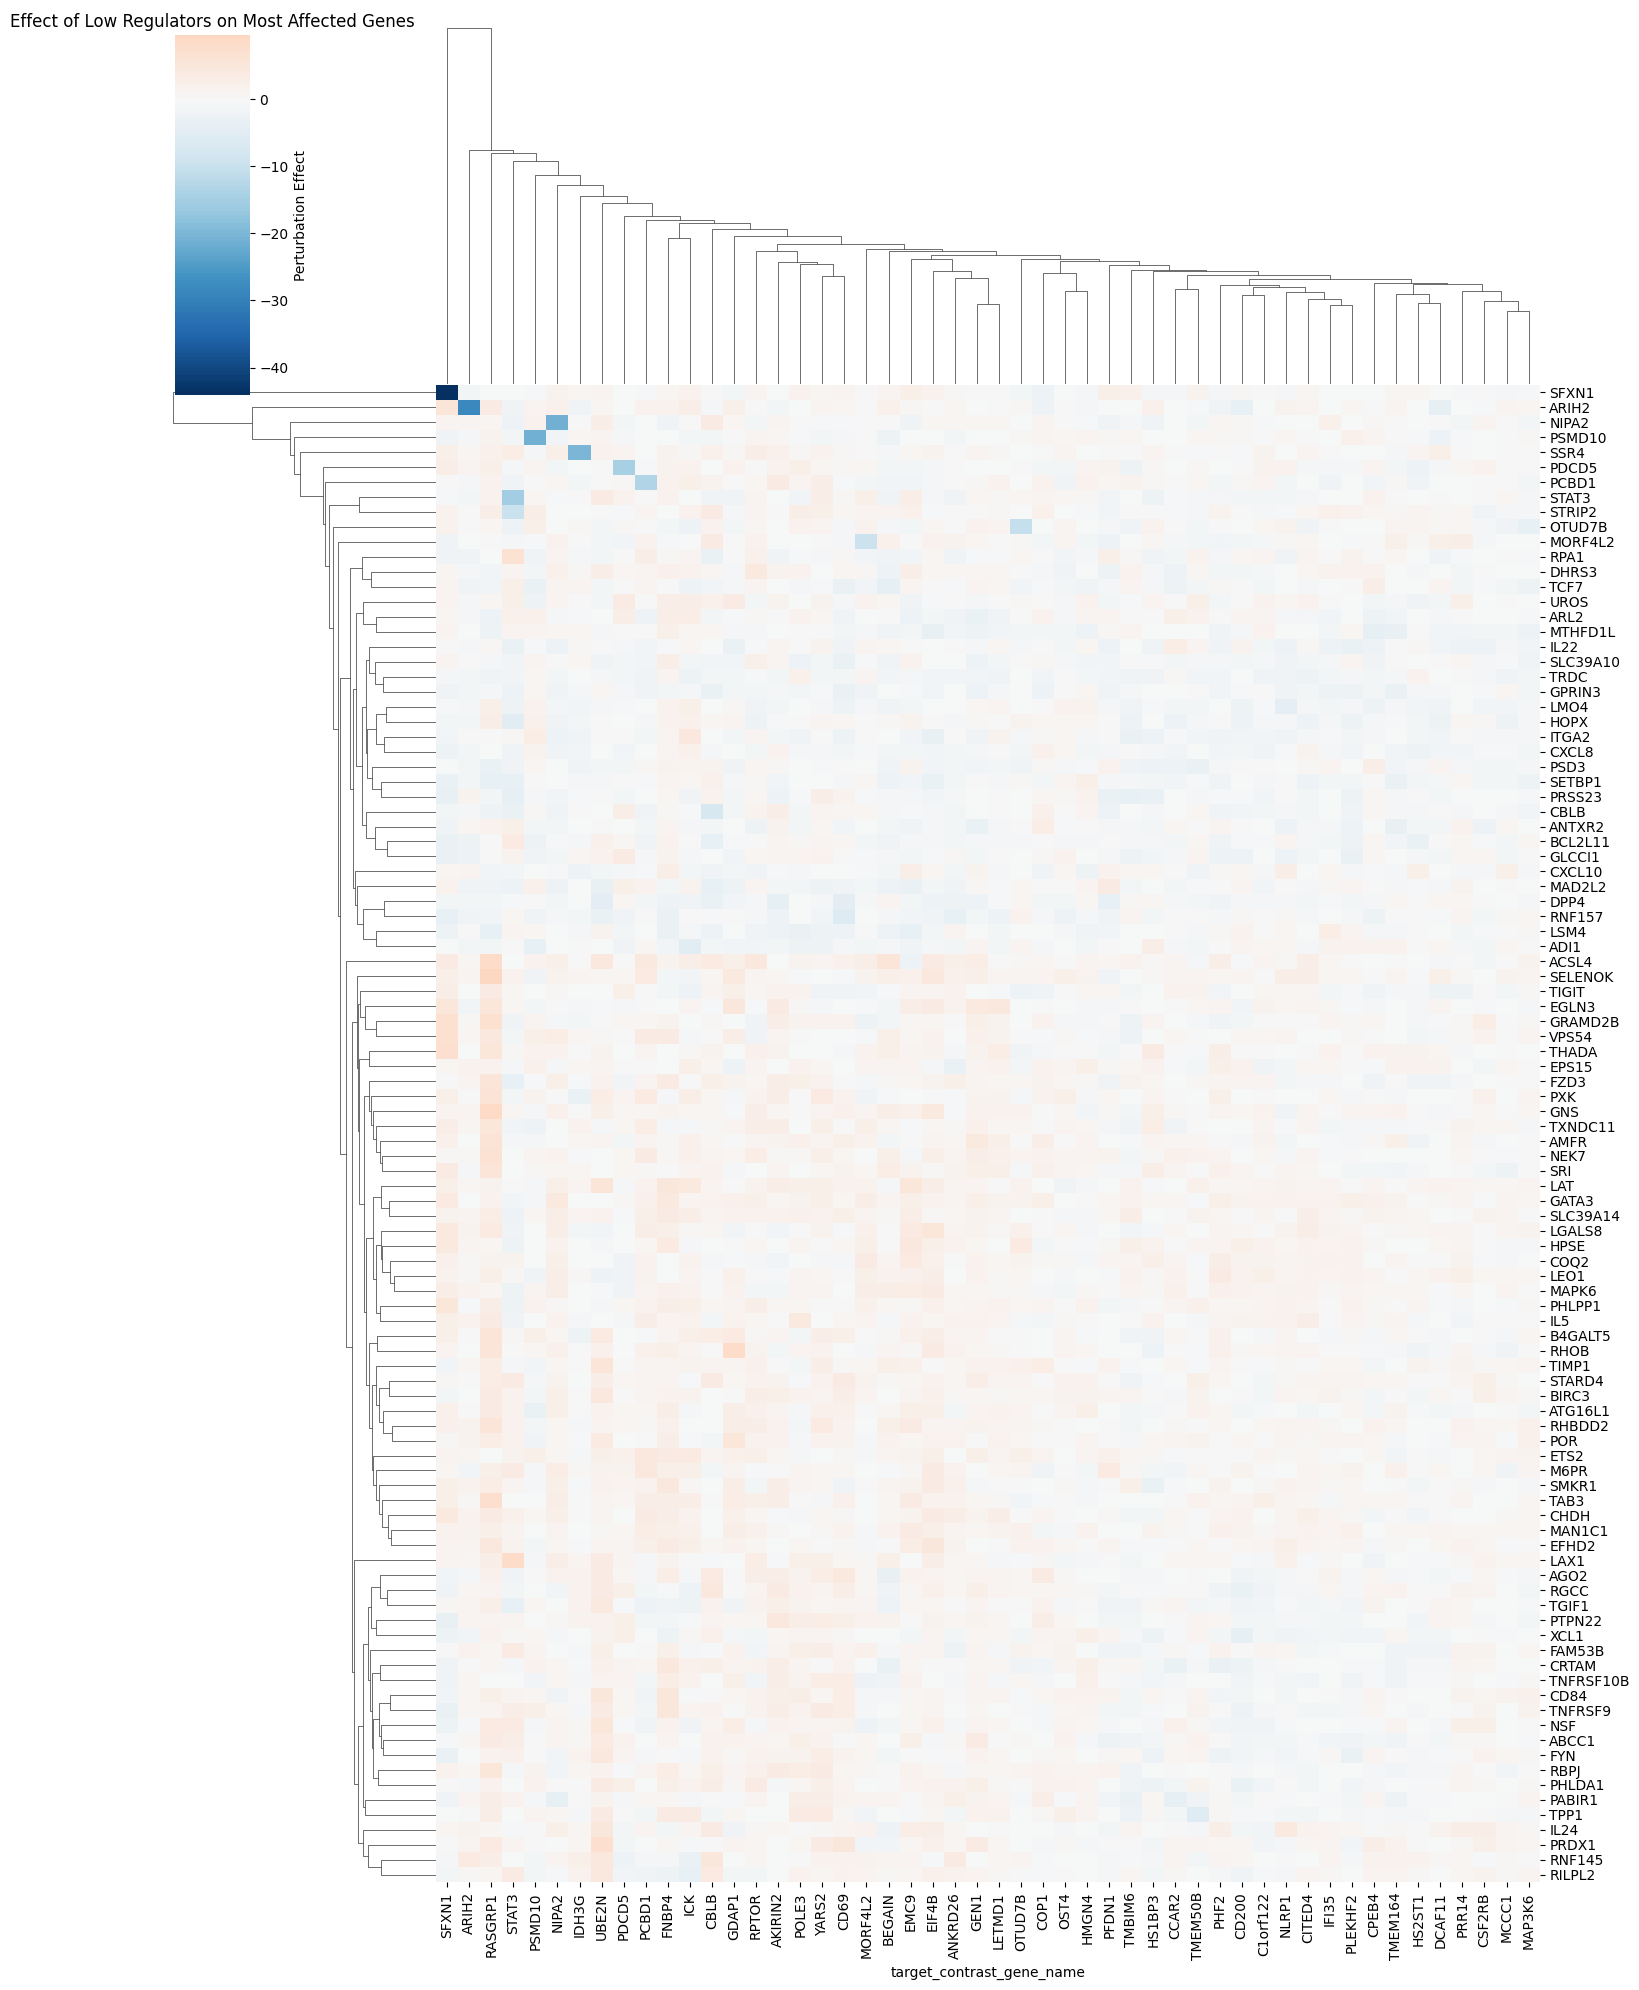

In [38]:
low_regs = coefs_wide['Th1'].sort_values()[0:50].index.tolist()
# Get the perturbation effects for low_regs
perturb_effects = X_perturbs[low_regs]

# Get the 200 genes most affected by these perturbations
# Calculate mean absolute effect across perturbations
mean_effects = perturb_effects.abs().mean(axis=1)
top_affected_genes = mean_effects.nlargest(100).index

# Create clustered heatmap
plt.figure(figsize=(15, 20))
sns.clustermap(perturb_effects.loc[top_affected_genes], 
               center=0,
               cmap='RdBu_r',
               xticklabels=True,
               yticklabels=True,
               figsize=(15, 20),
               cbar_kws={'label': 'Perturbation Effect'})
plt.title('Effect of Low Regulators on Most Affected Genes')

In [759]:
st='Th1'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
mod_ix = 
comps = pd.DataFrame(p2t_model.pcas[mod_ix].components_, columns=X_perturbs.columns)
top = p2t_model.models[mod_ix].coef_.argmax()
# plt.plot(top, '.')
comps.iloc[top,:].sort_values()

target_contrast_gene_name
GIN1      -0.059474
HELZ      -0.058324
DNTTIP1   -0.055660
CCDC6     -0.055113
AP3M1     -0.053719
             ...   
PHF12      0.049750
SMARCB1    0.050056
ZBTB48     0.050656
SIN3B      0.054089
NSD1       0.091510
Name: 29, Length: 3861, dtype: float64

In [ ]:
st = 'Treg'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()

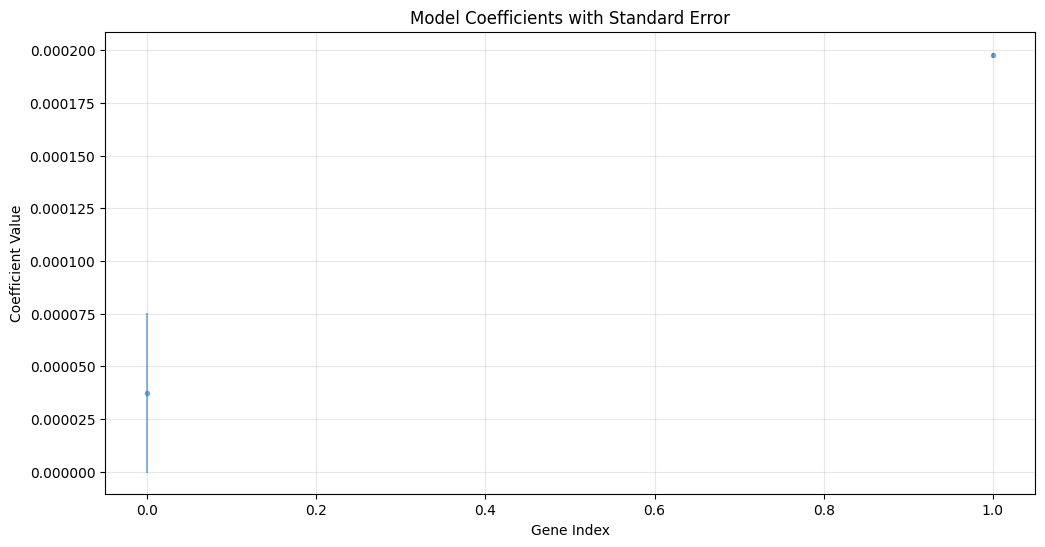

coef_mean  coef_sem
coef_mean   0.000037  0.000038
coef_sem    0.000198  0.000001

In [761]:
coefs = p2t_model.get_coefs()
coefs_mean = coefs.mean(axis=0)
coefs_sem = coefs.sem(axis=0)

# Create DataFrame with mean and SEM
coefs_df = pd.DataFrame({
    'coef_mean': coefs_mean,
    'coef_sem': coefs_sem
})

# Plot mean coefficients with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(range(len(coefs_mean)), coefs_mean, yerr=coefs_sem, fmt='.', alpha=0.5)
plt.title('Model Coefficients with Standard Error')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient Value')
plt.grid(True, alpha=0.3)
plt.show()

coefs_df

In [452]:
import decoupler as dc

In [594]:
msigdb_table = decoupler.op.resource('MSigDB')

In [645]:
msigdb_table.collection.value_counts()

collection
immunesigdb                           1211234
go_biological_process                 1028339
human_phenotype_ontology               643992
chemical_and_genetic_perturbations     520915
mirna_targets_mirdb                    468097
tf_targets_gtrf                        278854
reactome_pathways                      207025
tf_targets_legacy                      199207
cell_type_signatures                   193040
go_cellular_component                  177903
go_molecular_function                  176652
cancer_modules                          68839
wikipathways                            59269
vaccine_response                        58531
cancer_gene_neighborhoods               57559
mirna_targets_legacy                    44535
oncogenic_signatures                    39253
kegg_pathways                           27028
positional                              24437
pid_pathways                            16547
hallmark                                11319
biocarta_pathways      

In [669]:
ctsig_table = msigdb_table[msigdb_table.collection == 'kegg_pathways']
immunesig_db_table = msigdb_table[msigdb_table['collection'] == 'immunesigdb']

In [681]:
[x for x in ctsig_table.geneset if 'T_CELL' in x]

['KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CE

In [670]:
net = ctsig_table.rename({'geneset':'source', 'genesymbol':'target'}, axis=1)
net = net.drop_duplicates(subset=['source', 'target'])

In [671]:
input_df = coefs_wide[['Th1']].T
input_df.index.name = None

In [695]:
scores  = decoupler.mt.decouple(coefs_wide[['Th2']].T.abs(), net=net)


AttributeError: 'NoneType' object has no attribute '__name__'

In [689]:
scores.T

Th2
KEGG_ACUTE_MYELOID_LEUKEMIA                      1.319735
KEGG_ADHERENS_JUNCTION                           1.030324
KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY             1.289013
KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM  1.138446
KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION   0.780028
...                                                   ...
KEGG_VASOPRESSIN_REGULATED_WATER_REABSORPTION    0.702157
KEGG_VEGF_SIGNALING_PATHWAY                      1.202326
KEGG_VIBRIO_CHOLERAE_INFECTION                   1.225944
KEGG_VIRAL_MYOCARDITIS                           0.920714
KEGG_WNT_SIGNALING_PATHWAY                       1.233907

[154 rows x 1 columns]

In [691]:
pvals.T.sort_values('Th2')

Th2
KEGG_JAK_STAT_SIGNALING_PATHWAY               0.308000
KEGG_CHRONIC_MYELOID_LEUKEMIA                 0.435803
KEGG_CYSTEINE_AND_METHIONINE_METABOLISM       0.435803
KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION   0.435803
KEGG_DNA_REPLICATION                          0.435803
...                                                ...
KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS  0.994032
KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM          0.994032
KEGG_REGULATION_OF_ACTIN_CYTOSKELETON         0.994032
KEGG_CELL_ADHESION_MOLECULES_CAMS             0.994032
KEGG_GLYCOLYSIS_GLUCONEOGENESIS               0.995885

[154 rows x 1 columns]

(None,
 array(['IL4R', 'STAT6', 'STAT2', 'CSF2RB', 'CREBBP', 'EP300', 'AKT3',
        'STAT1', 'STAT3', 'CBLB', 'IL10RA', 'IFNGR2', 'AKT1', 'PTPN11',
        'IRF9', 'STAT5A', 'IFNAR1', 'IL4', 'PIK3CB', 'GRB2', 'CCND2',
        'PIK3CA', 'IL12RB2', 'AKT2', 'PIK3CG'], dtype='<U10'))

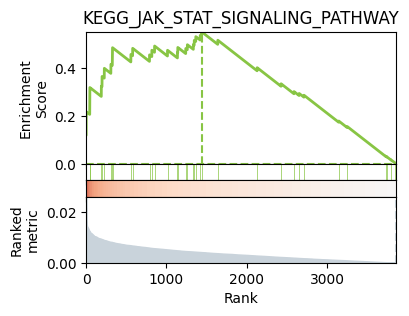

In [693]:
decoupler.pl.leading_edge(coefs_wide.abs(), net=net, stat='Th2', name='KEGG_JAK_STAT_SIGNALING_PATHWAY')

In [562]:
tf_acts

Androgen      EGFR  Estrogen   Hypoxia  JAK-STAT      MAPK      NFkB  \
Treg  0.858993  1.032567  0.904279  1.045801  1.044117  1.086472  1.102279   

          PI3K      TGFb     TNFa     Trail      VEGF       WNT       p53  
Treg  0.977776  0.872948  1.08322 -1.208076  1.095913 -0.798849  0.963823

array([[<Axes: title={'center': 'Treg'}>]], dtype=object)

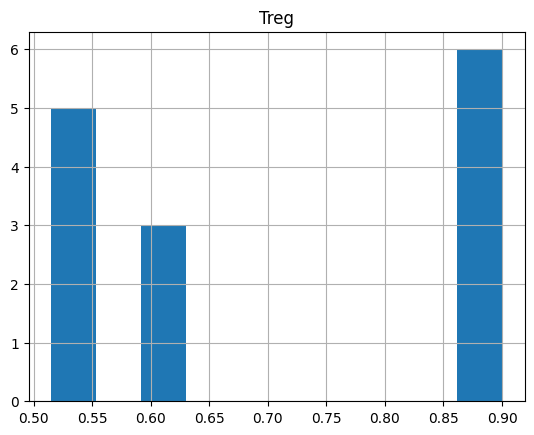

In [561]:
tf_padj.T.hist()

## Check single-cell states 

In [8]:
import glob
stim_sc_files = glob.glob(f'{datadir}/**/*Stim8hr*postQC.h5ad', recursive=True)
# Pick some lanes
stim_sc_files = stim_sc_files[0:10]

In [ ]:
import h5py
import anndata as ad
from tqdm import tqdm

adatas = []
all_highly_variable_genes = []
for f in tqdm(stim_sc_files):
    adata = ad.experimental.read_lazy(f)
    adata_ntc = adata[adata.obs['perturbed_gene_name'] == 'NTC'].copy()

    X_dask = adata_ntc.X
    X_dask = X_dask.map_blocks(lambda x: x.toarray(), dtype=X_dask.dtype, meta=np.array([]))
    col_sums = X_dask.sum(axis=0).compute()  # Compute sum along rows (axis=1)
    gene_mask = col_sums > 2

    adata_ntc = adata_ntc[:, gene_mask].copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    
    highly_variable_genes = set(adata.var_names[adata.var["highly_variable"]])
    all_highly_variable_genes.append(highly_variable_genes)
    adatas.append(adata)

In [45]:
from collections import Counter

## select the genes appears more than two lanes
gene_counts = Counter(gene for genes in all_highly_variable_genes for gene in genes)
selected_genes = {gene for gene, count in gene_counts.items() if count > 2}
print( len(selected_genes) )

for i,a in enumerate(adatas):
    common_genes = list(set(a.var_names) & selected_genes)
    a = a[:, common_genes].copy()
    a.obs = a.obs.to_dataframe()
    a.var = a.var.to_dataframe()
    output_path = f'{datadir}/tmp/Stim8hr_NTCs_preprocessed_s{i}.h5ad'
    a.write_h5ad(output_path)

1774


In [47]:
%%time
data_dict = {}
for i,_ in enumerate(adatas):
    data_dict.update({i:f'{datadir}/tmp/Stim8hr_NTCs_preprocessed_s{i}.h5ad'})

ad.experimental.concat_on_disk(
    data_dict,
    f'{datadir}/tmp/Stim8hr_NTCs_merged.h5ad',
    label='sample_id',
)

CPU times: user 3.22 s, sys: 2.65 s, total: 5.87 s
Wall time: 12.7 s


In [61]:
adata = sc.read_h5ad(f'{datadir}/tmp/Stim8hr_NTCs_merged.h5ad', backed=False)

In [63]:
sc.pp.pca(adata, n_comps=50)

In [86]:
adata.var = a.var[['gene_ids', 'gene_name']].loc[adata.var_names].copy()

In [87]:
adata.var_names = adata.var['gene_name'].values

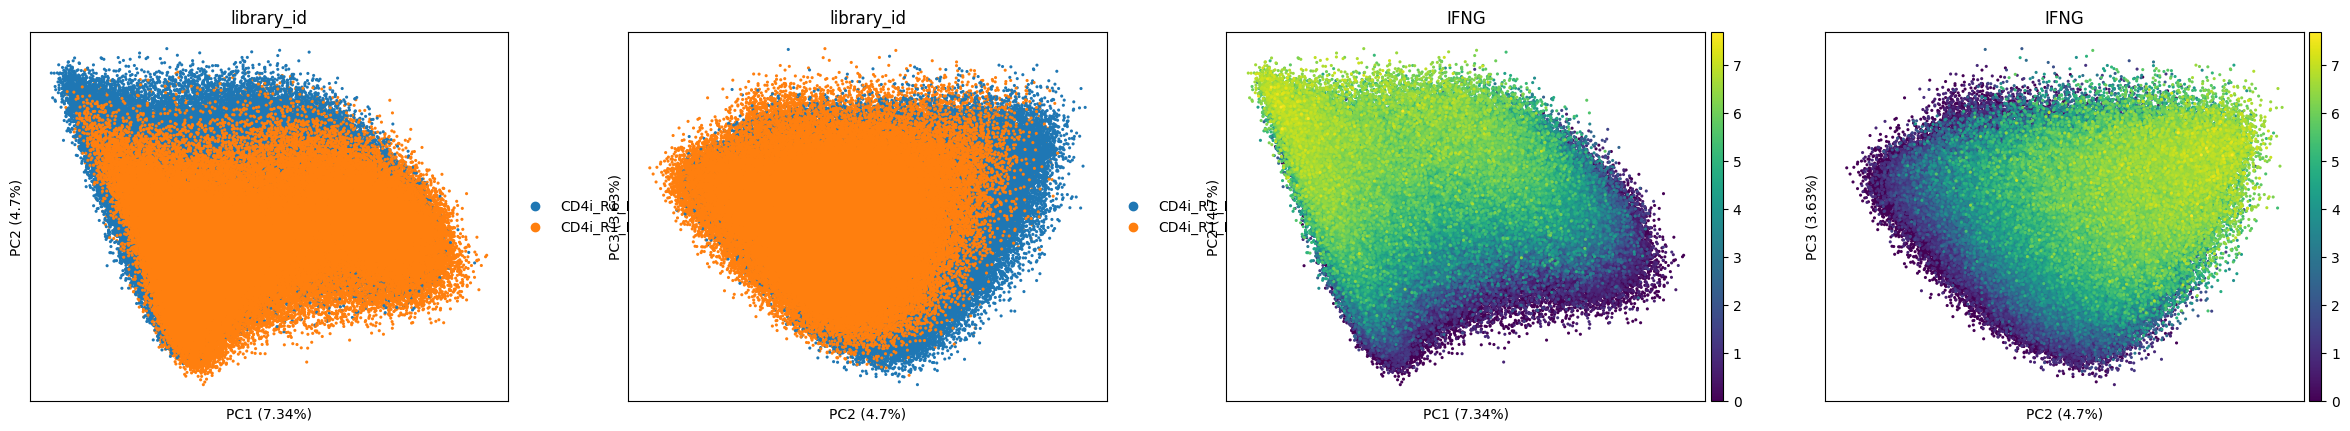

In [92]:
sc.pl.pca(adata, annotate_var_explained=True, color=['library_id', 'IFNG'], size=20, components=['1,2', '2,3'])

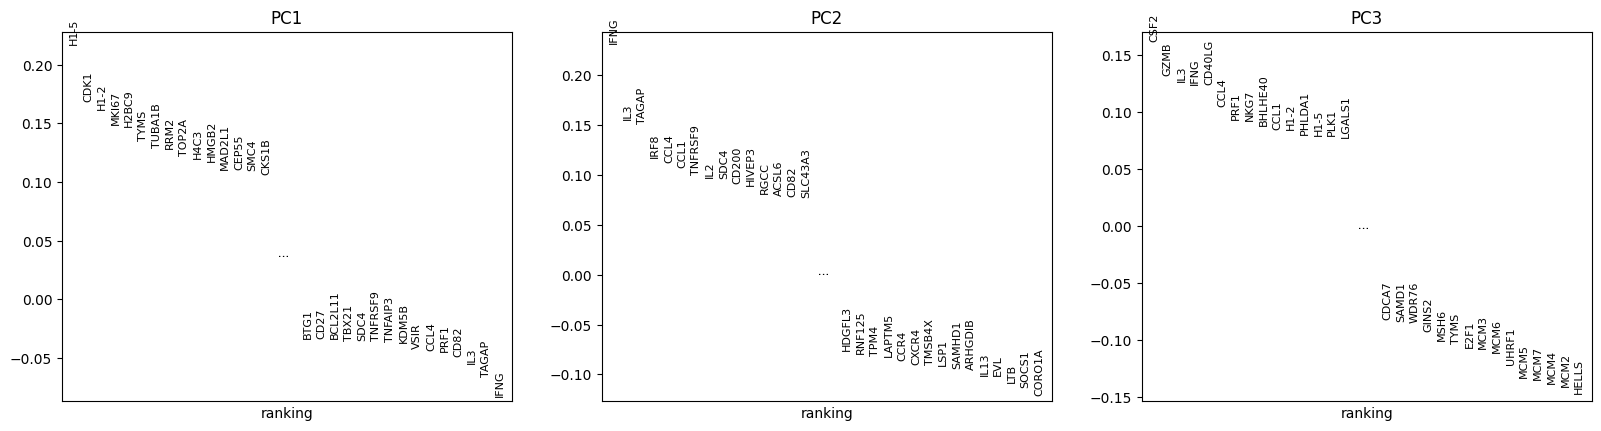

In [90]:
sc.pl.pca_loadings(adata)

In [94]:
sc.pp.neighbors(adata)


In [95]:
sc.tl.umap(adata)

In [96]:
sc.pl.umap(adata, color=['donor_id', 'IL4'])

KeyError: 'Could not find key donor_id in .var_names or .obs.columns.'

<Figure size 1455.6x480 with 0 Axes>

In [ ]:

SPARSE_CHUNK_SIZE = 100_000
adatas = []
all_highly_variable_genes = []
for f in tqdm(stim_sc_files):
    with h5py.File(f, "r") as f:
        adata = ad.AnnData(
            obs=ad.io.read_elem(f["obs"]),
            var=ad.io.read_elem(f["var"]),
        )
        adata.X = ad.experimental.read_elem_lazy(
            f["X"], chunks=(SPARSE_CHUNK_SIZE, adata.shape[1])
        )

    # # filtering
    # pass_filter_mask = adata.obs["pass_filter"] == "full"
    # adata = adata[pass_filter_mask, :].copy()

    # sc.pp.normalize_total(adata)
    # sc.pp.log1p(adata)
    # sc.pp.highly_variable_genes(adata, n_top_genes=2000)

    highly_variable_genes = set(adata.var_names[adata.var["highly_variable"]])
    all_highly_variable_genes.append(highly_variable_genes)
    adatas.append(adata)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
adata_s = anndata.read_lazy(f'{datadir}/tmp/CD4iR1_Psomagen_merged.DE_pseudobulk.h5ad', backed=True)

In [202]:
adata_pbulk = sc.read_h5ad(f'{datadir}/CD4iR1_Psomagen_merged.DE_pseudobulk.h5ad', backed=True)


View of AnnData object with n_obs × n_vars = 47346 × 18117 backed at '/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/CD4iR1_Psomagen_merged.DE_pseudobulk.h5ad'
    obs: '10xrun_id', 'cell_sample_id', 'donor_id', 'culture_condition', 'guide_id', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type', 'n_cells', 'total_counts', 'keep_min_cells', 'keep_effective_guides', 'keep_total_counts', 'keep_for_DE', 'keep_test_genes', 'log10_n_cells'
    var: 'gene_ids', 'gene_name'

In [ ]:
pbulk_adata = sc.read_h5ad(f'{DATADIR}/Diff035_pseudobulk.h5ad')
pbulk_adata.obs['sample_id'] = pbulk_adata.obs['culture_condition'].copy()
pbulk_adata.obs['culture_condition'] = pbulk_adata.obs['sample_id'].str.split('_').str[0]
pbulk_adata.obs['timepoint'] = pbulk_adata.obs['sample_id'].str.split('_').str[1]
pbulk_adata.obs['timepoint'] = np.where(pbulk_adata.obs['timepoint'].isna(), 'Day0', pbulk_adata.obs['timepoint'])

# Check if values in the array are integers
array_values = pbulk_adata.layers['sum']
is_integer_array = np.all(np.equal(np.mod(array_values, 1), 0))
pbulk_adata.layers['sum'] = pbulk_adata.layers['sum'].astype(int)
print(f"All values are integers: {is_integer_array}")

# Filter out lowly expressed genes
pbulk_adata.var['mean_expression'] = pbulk_adata.layers['sum'].mean(axis=0)
pbulk_adata = pbulk_adata[:, pbulk_adata.var['mean_expression'] > 1].copy()

# HVGs
pbulk_adata.X = pbulk_adata.layers['sum'].copy()
sc.pp.normalize_total(pbulk_adata)
sc.pp.log1p(pbulk_adata)

In [327]:
target_hits = get_DE_results_long(adata_de, targets=['GATA3'])
target_hits = target_hits[target_hits['culture_condition'] == cond]
signif_genes = target_hits[target_hits['significant']]
signif_genes['class'] = np.where(np.sign(target_hits[target_hits['significant']].zscore) < 0, 'neg', 'pos')
signif_gene_classes = signif_genes.groupby('class')['gene'].apply(list).to_dict()
signif_gene_classes

/tmp/ipykernel_2698264/4045715312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_genes['class'] = np.where(np.sign(target_hits[target_hits['significant']].zscore) < 0, 'neg', 'pos')


{'neg': ['ADAM19',
  'ANXA4',
  'ATP8B2',
  'CD44',
  'CLINT1',
  'CYLD',
  'EEIG1',
  'EML4',
  'ERN1',
  'GIMAP4',
  'GLUL',
  'ICAM2',
  'IFITM2',
  'IKZF1',
  'IL10RA',
  'IL32',
  'KLF2',
  'MORC2',
  'MYD88',
  'NME2',
  'NSA2',
  'PXN',
  'RASA3',
  'S100A10',
  'S100A11',
  'SAMD3',
  'SLFN5',
  'SOS1',
  'TNFSF10'],
 'pos': ['ADA',
  'CD3G',
  'CD7',
  'CD74',
  'CYFIP2',
  'FTH1',
  'GRK2',
  'HMGN1',
  'LBR',
  'MAL',
  'MAP4K4',
  'NHERF1',
  'RABL6',
  'SEPTIN6',
  'SNRPC',
  'STAU2',
  'YBX1']}

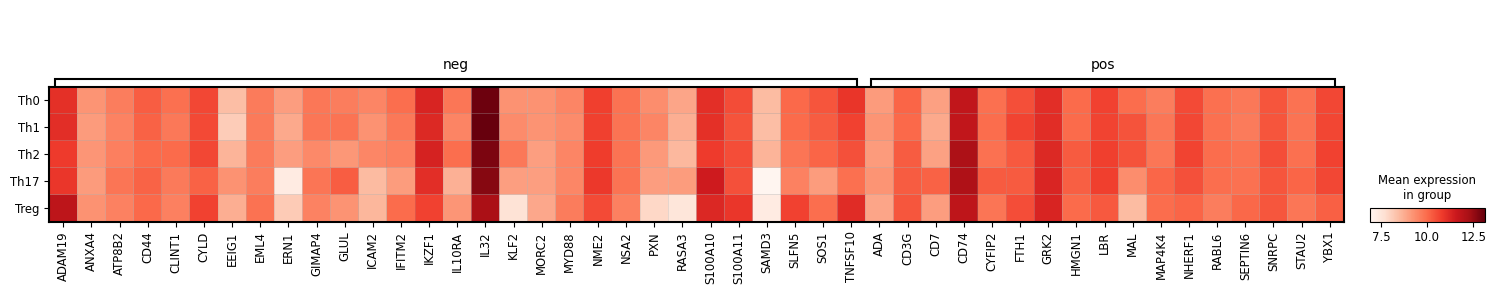

In [331]:
sc.pl.matrixplot(pbulk_adata[pbulk_adata.obs.culture_condition != 'Day0'], signif_gene_classes, groupby='culture_condition', cmap='Reds')

In [137]:
# Store evaluation results for different numbers of PCs
pc_eval_results = []

from tqdm.notebook import tqdm
for d in tqdm(np.linspace(10,100, 10), desc="Testing different PC counts"):
    p2t_model = Perturb2TissueModel(pca_transform=True, n_pcs=int(d), n_splits=3, n_repeats=3)
    p2t_model.fit(X_perturbs, y_target, model_id=f'Stim8hr_PC{int(d)}', frac_top_hvgs=0.50)
    
    # Get evaluation summary
    eval_summary = p2t_model.summarize_eval()
    eval_summary['n_pcs'] = int(d)
    
    # Store results
    pc_eval_results.append(eval_summary)


Testing different PC counts:   0%|          | 0/10 [00:00<?, ?it/s]

Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes


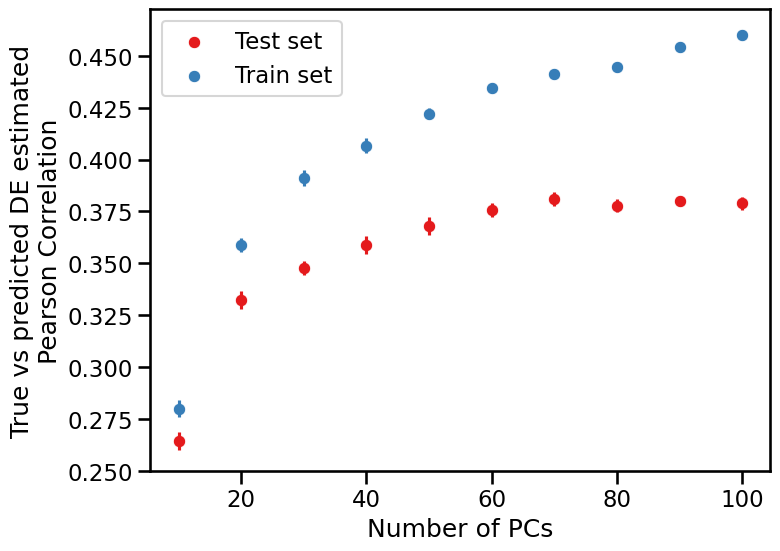

In [143]:
sns.set_context('talk')
# Combine all results into a single DataFrame
pc_eval_df = pd.concat(pc_eval_results)
# Create a figure with error bars showing standard error
fig, ax = plt.subplots(figsize=(8, 6))

# Use Set1 color palette
palette = sns.color_palette("Set1")

# Test pearson with matching color for points and error bars
sns.scatterplot(data=pc_eval_df, x='n_pcs', y='test_pearson', label='Test set', ax=ax, color=palette[0])
ax.errorbar(pc_eval_df['n_pcs'], pc_eval_df['test_pearson'], 
            yerr=pc_eval_df['test_pearson_se'], fmt='none', alpha=1, color=palette[0])

# Train pearson with matching color for points and error bars
sns.scatterplot(data=pc_eval_df, x='n_pcs', y='train_pearson', label='Train set', ax=ax, color=palette[1])
ax.errorbar(pc_eval_df['n_pcs'], pc_eval_df['train_pearson'], 
            yerr=pc_eval_df['train_pearson_se'], fmt='none', alpha=1, color=palette[1])

plt.xlabel('Number of PCs')
plt.ylabel('True vs predicted DE estimated\nPearson Correlation')
plt.legend()

### Simple correlation

Text(0.5, 1.0, 'Correlation: r = 0.202, p = 4.055e-65')

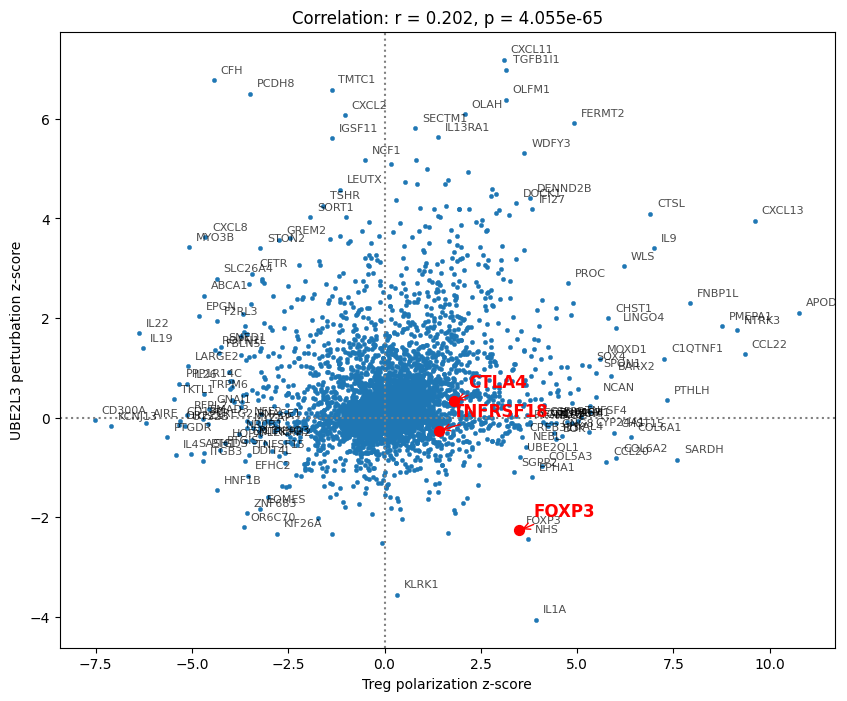

In [190]:
pseq_target = 'UBE2L3'
pol_condition = 'Treg'

perturbseq_results = get_DE_results_long(adata_de, targets=[pseq_target], effect_estimates=['log_fc'])
perturbseq_results = perturbseq_results.set_index('gene_name')[['log_fc', 'culture_condition']]
perturbseq_results = perturbseq_results[perturbseq_results['culture_condition'] == 'Stim8hr' ].copy()

polarization_results = all_results_df[all_results_df['contrast'] == pol_condition].set_index('variable')
polarization_results = polarization_results.rename({'log_fc': 'zscore_polarization'}, axis=1)
compare_df = pd.concat([perturbseq_results, polarization_results], axis=1).dropna()

# Calculate correlation coefficient and p-value
from scipy import stats
corr, p_value = stats.pearsonr(compare_df['zscore_polarization'], compare_df['log_fc'])

# Create scatter plot with correlation and p-value in title
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=compare_df, x='zscore_polarization', y='log_fc', s=10, edgecolor=None, ax=ax)

# Add quadrant lines
plt.axhline(y=0, linestyle='dotted', color='gray')
plt.axvline(x=0, linestyle='dotted', color='gray')

# Annotate top genes in each quadrant
# Get top 5 genes by absolute distance from origin in each quadrant
for quadrant in ['top_right', 'top_left', 'bottom_right', 'bottom_left']:
    if quadrant == 'top_right':
        mask = (compare_df['zscore_polarization'] > 0) & (compare_df['log_fc'] > 0)
    elif quadrant == 'top_left':
        mask = (compare_df['zscore_polarization'] < 0) & (compare_df['log_fc'] > 0)
    elif quadrant == 'bottom_right':
        mask = (compare_df['zscore_polarization'] > 0) & (compare_df['log_fc'] < 0)
    else:  # bottom_left
        mask = (compare_df['zscore_polarization'] < 0) & (compare_df['log_fc'] < 0)
    
    quadrant_df = compare_df[mask].copy()
    if len(quadrant_df) > 0:
        # Calculate distance from origin
        quadrant_df['distance'] = np.sqrt(quadrant_df['zscore_polarization']**2 + quadrant_df['log_fc']**2)
        # Get top 5 genes
        top_genes = quadrant_df.nlargest(30, 'distance')
        
        # Annotate points
        for idx, row in top_genes.iterrows():
            ax.annotate(idx, 
                       (row['zscore_polarization'], row['log_fc']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.7)

# Highlight and annotate CTLA4 and FOXP3
highlight_genes = ['CTLA4', 'FOXP3', 'IKFZ2', 'TNFRSF18']
for gene in highlight_genes:
    if gene in compare_df.index:
        row = compare_df.loc[gene]
        # Plot highlighted point
        ax.scatter(row['zscore_polarization'], row['log_fc'], 
                  color='red', s=50, zorder=3)
        # Add annotation with arrow
        ax.annotate(gene,
                   (row['zscore_polarization'], row['log_fc']),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=12, fontweight='bold',
                   color='red',
                   arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel(f'{pol_condition} polarization z-score')
plt.ylabel(f'{pseq_target} perturbation z-score')
plt.title(f'Correlation: r = {corr:.3f}, p = {p_value:.3e}')

In [182]:
df = all_results_df[all_results_df['contrast'] == 'Treg']
df.set_index('variable').loc['CTLA4']

baseMean       2840.803695
log_fc            1.807931
lfcSE             0.252782
stat              7.152129
p_value                0.0
adj_p_value            0.0
contrast              Treg
zscore            7.152129
Name: CTLA4, dtype: object

In [120]:
pseq_target = 'MTOR'
perturbseq_results = get_DE_results_long(adata_de, targets=[pseq_target], effect_estimates=['zscore'])
perturbseq_results.set_index('gene_name').groupby('culture_condition').significant.value_counts()

Series([], Name: count, dtype: int64)

In [88]:
perturbseq_results = get_DE_results_long(adata_de, targets=[pseq_target], effect_estimates=['zscore'])
perturbseq_results.set_index('gene_name').loc['FOXP3']

index   gene    zscore  adj_p_value  significant  \
gene_name                                                                       
FOXP3      ENSG00000049768_Stim8hr  FOXP3 -4.610460     0.022389         True   
FOXP3         ENSG00000049768_Rest  FOXP3 -3.431448     0.999792        False   

          culture_condition  target_contrast target_contrast_gene_name  
gene_name                                                               
FOXP3               Stim8hr  ENSG00000049768                     FOXP3  
FOXP3                  Rest  ENSG00000049768                     FOXP3

In [263]:
adata_de.var_names = adata_de.var['gene_name'].copy()
# Create a dictionary to store correlation results for all polarization conditions
all_correlation_results = {}

# Loop through all polarization conditions
for pol_condition in all_results['contrast'].unique():
    polarization_results = all_results[all_results['contrast'] == pol_condition].set_index('variable')
    polarization_results['zscore_polarization'] = polarization_results['log_fc'] / polarization_results['lfcSE']
    
    common_gs = np.intersect1d(polarization_results.index, adata_de.var['gene_name'])
    
    polarization_results = polarization_results.loc[common_gs].copy()
    pseq_results = pd.DataFrame(adata_de[:, common_gs].layers['zscore'], columns=common_gs, index=adata_de.obs_names)
    
    # Compute correlation coefficient and p-value for each row in pseq_results
    correlation_results = {}
    for idx in pseq_results.index:
        row_data = pseq_results.loc[idx]
        corr, p_value = stats.pearsonr(polarization_results['zscore_polarization'], row_data)
        correlation_results[idx] = {'correlation': corr, 'p_value': p_value, 'polarization': pol_condition}
    
    # Store results for this polarization condition
    all_correlation_results[pol_condition] = correlation_results

# Convert all results to a single DataFrame
correlation_dfs = []
for pol_condition, results in all_correlation_results.items():
    df = pd.DataFrame(results).T
    df.columns = ['correlation', 'p_value', 'polarization']
    correlation_dfs.append(df)

correlation_df = pd.concat(correlation_dfs)
correlation_df['target_gene_name'] = correlation_df.index.map(lambda x: adata_de.obs.loc[x, 'target_contrast_gene_name'])
correlation_df['condition'] = correlation_df.index.map(lambda x: adata_de.obs.loc[x, 'culture_condition'])

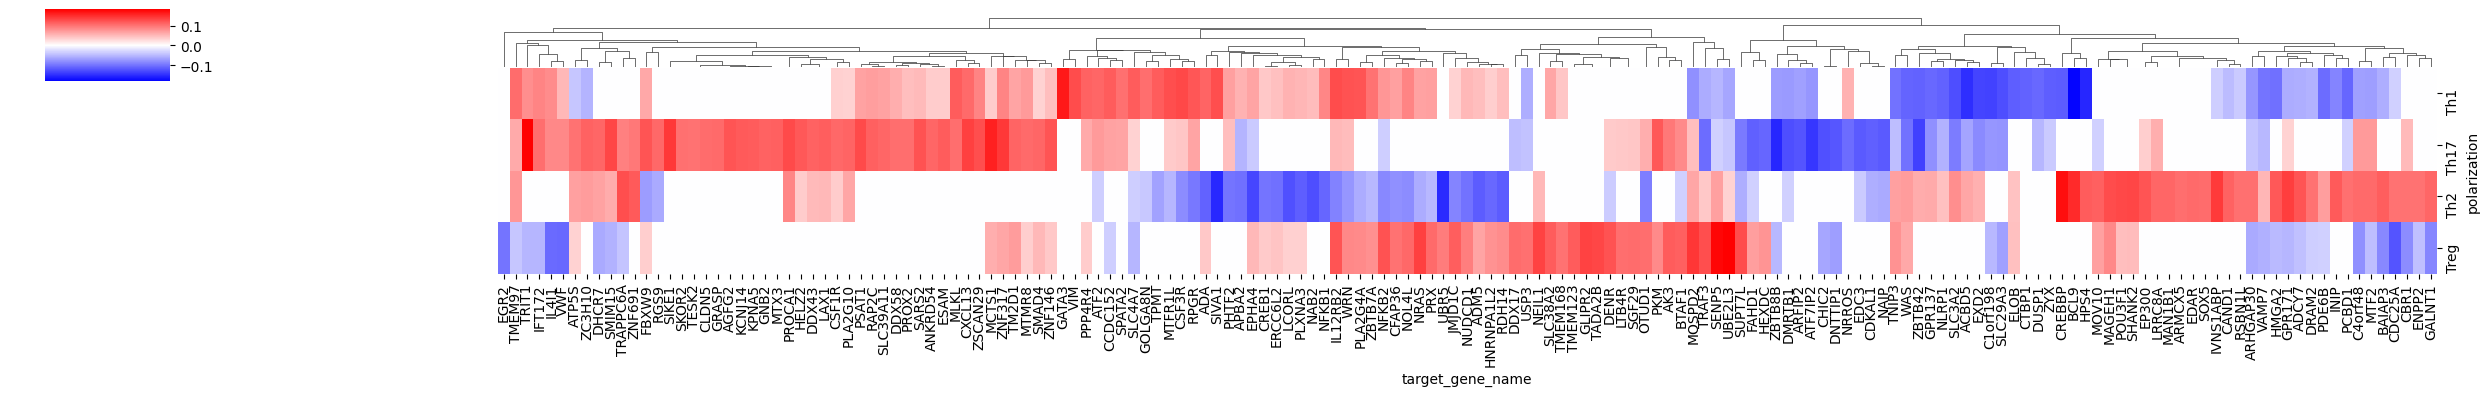

In [295]:
corr_wide = correlation_df.pivot_table(index=['target_gene_name', 'condition'], values='correlation', columns='polarization')
pval_wide = correlation_df.pivot_table(index=['target_gene_name', 'condition'], values='p_value', columns='polarization')
corr_wide[pval_wide >= 0.01] = 0
corr_wide = corr_wide.reset_index()
corr_wide = corr_wide[corr_wide['condition'] == 'Stim8hr'].drop('condition', axis=1).set_index('target_gene_name')

sns.clustermap(corr_wide[corr_wide.abs().max(1) > 0.1].astype(float).T, cmap='bwr', center=0, figsize=(25,4), xticklabels=True, row_cluster=False)

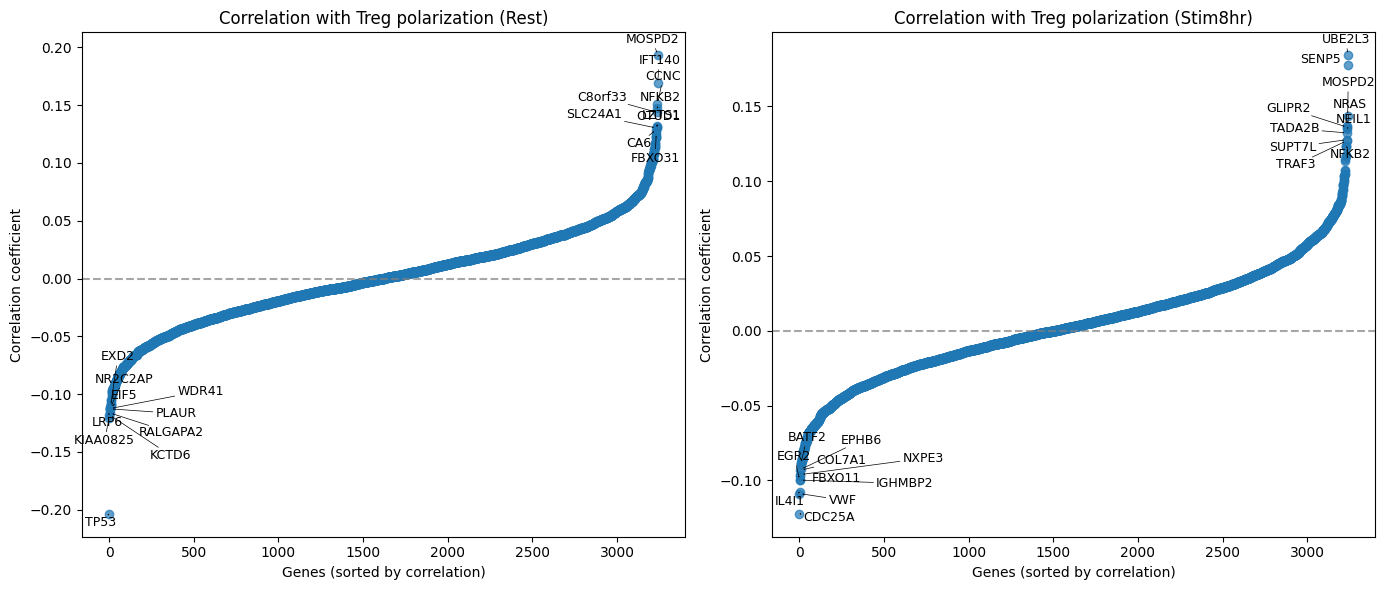

In [261]:
from adjustText import adjust_text
# Create a figure with 2 subplots (one for each condition)
ntop = 10
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
conditions = correlation_df['condition'].unique()

for i, condition in enumerate(conditions):
    # Filter data for this condition
    condition_df = correlation_df[correlation_df['condition'] == condition].copy()
    condition_df = condition_df.sort_values('correlation')
    
    # Create scatterplot
    axes[i].scatter(range(len(condition_df)), condition_df['correlation'], alpha=0.7)
    
    # Get top and bottom genes to annotate
    top_genes = condition_df.nlargest(ntop, 'correlation')
    bottom_genes = condition_df.nsmallest(ntop, 'correlation')
    genes_to_annotate = pd.concat([top_genes, bottom_genes])
    
    # Annotate points with adjustText to avoid overlaps
    texts = []
    for _, row in genes_to_annotate.iterrows():
        idx = condition_df.index.get_loc(row.name)
        text = axes[i].text(idx, row['correlation'], row['target_gene_name'], 
                          fontsize=9, ha='center', va='center')
        texts.append(text)
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5), ax=axes[i])
    
    # Add horizontal line at y=0
    axes[i].axhline(y=0, linestyle='--', color='gray', alpha=0.7)
    
    # Set title and labels
    axes[i].set_title(f'Correlation with {pol_condition} polarization ({condition})')
    axes[i].set_xlabel('Genes (sorted by correlation)')
    axes[i].set_ylabel('Correlation coefficient')

plt.tight_layout()